In [2]:
import psycopg2
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
from collections import defaultdict

# User Input Required

In [3]:
#Enter Regional Benchmark Name
region_name = 'Yorkshire and The Humber'

#Enter Local Authority Benchmark Name
local_authority_name = 'Leeds'

#Enter list of LSOAs for the study area
study_area_lsoa_list = [
    'E01011284', 'E01011293', 'E01011338', 'E01011354', 'E01011355', 'E01011357', 'E01011358', 'E01011360',
    'E01011361', 'E01011363', 'E01011435', 'E01011440', 'E01011441', 'E01011442', 'E01011443', 'E01011444',
    'E01011445', 'E01011446', 'E01011447', 'E01011448', 'E01011449', 'E01011450', 'E01011451', 'E01011478',
    'E01011479', 'E01011480', 'E01011481', 'E01011482', 'E01011483', 'E01011668', 'E01011669', 'E01011670',
    'E01011671', 'E01011673', 'E01011678', 'E01011681', 'E01011691', 'E01011692', 'E01011693', 'E01032946',
    'E01033002', 'E01033003', 'E01033008', 'E01033010', 'E01033011', 'E01033013', 'E01033015', 'E01033016',
    'E01033021', 'E01033031', 'E01033033', 'E01033035', 'E01035041', 'E01035042', 'E01035043', 'E01035044',
    'E01035045', 'E01035047', 'E01035054']

#Enter file path for saving images
image_path=r'N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs'

# 1. Connect to Geodatabase

In [23]:
# --- DB connection params ---
conn_params = {
    'host': 'PRIORPSRV03',
    'port': 5432,
    'dbname': 'gis',    
}

# --- Connect to Postgres ---
conn = psycopg2.connect(**conn_params)

# 2. Run SQL query to retrive required data

In [24]:
query = """
WITH selected_lsoas AS (
    SELECT DISTINCT lsoa21cd
    FROM uk_new.census2021_lsoa2021_pop_and_hholds
    
)
SELECT 
    s.lsoa21cd,
    a.*, e.*, ep.*, eth.*, hc.*, hs.*, ht.*, ind.*, ni.*, ph.*, pp.*, rel.*, stu.*
FROM selected_lsoas s
LEFT JOIN uk_new.census2021_lsoa2021_accommodation_type       a   ON s.lsoa21cd = a.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_education               e   ON s.lsoa21cd = e.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_english_proficiency     ep  ON s.lsoa21cd = ep.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_ethnicity               eth ON s.lsoa21cd = eth.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_household_composition   hc  ON s.lsoa21cd = hc.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_household_size          hs  ON s.lsoa21cd = hs.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_housing_tenure          ht  ON s.lsoa21cd = ht.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_industry                ind ON s.lsoa21cd = ind.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_national_identity       ni  ON s.lsoa21cd = ni.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_pop_and_hholds          ph  ON s.lsoa21cd = ph.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_passport_held           pp  ON s.lsoa21cd = pp.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_religion                rel ON s.lsoa21cd = rel.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_students                stu ON s.lsoa21cd = stu.lsoa21cd;
"""

# --- Load the query result ---
uk = pd.read_sql_query(query, conn)
conn.close()

# --- Step 1: Find and keep only the first 'lsoa21cd' column ---
lsoa_cols = [col for col in uk.columns if col.startswith('lsoa21cd')]
first_lsoa = lsoa_cols[0]

# --- Step 2: Drop all duplicate metadata columns and keep only the first lsoa21cd ---
columns_to_drop = [
    col for col in uk.columns if col in [
        'FID', 'data_time_period', 'data_web_link',
        'msoa21cd', 'msoa21nm', 'wd22cd', 'wd22nm', 'area_ha',
        'data_source', 'lsoa21nm', 'data_resolution',
        'lad22cd','rgn22cd','geometry'
    ] or (col.startswith('lsoa21cd') and col != first_lsoa)
]

# Rename and clean
uk = uk.rename(columns={first_lsoa: 'lsoa21cd'})
uk = uk.drop(columns=columns_to_drop)

# View cleaned data
uk.head()

,lsoa21cd,lsoa21cd,lad22nm,rgn22nm,detached_count,semi_detached_count,terraced_count,in_a_purpose_built_block_of_flats_or_tenement_count,part_of_a_converted_or_shared_house_including_bedsits_count,part_of_another_converted_building_count,in_commercial building_count,caravan_or_other_mobile_or_temporary_structure_count,detached_perc,semi_detached_perc,terraced_perc,in_a_purpose_built_block_of_flats_or_tenement_perc,part_of_a_converted_or_shared_house_including_bedsits_perc,part_of_another_converted_building_perc,in_commercial building_perc,caravan_or_other_mobile_or_temporary_structure_perc,dominant_accomodation_type_group,lsoa21cd,lad22nm,rgn22nm,no_qualifications_count,level_1_and_entry_level_qualifications_count,level_2_qualifications_count,apprenticeship_count,level_3_qualifications_count,level_4_qualifications_or_above_count,other_qualifications_count,total_edu_pop_count,no_qualifications_perc,level_1_and_entry_level_qualifications_perc,level_2_qualifications_perc,apprenticeship_perc,level_3_qualifications_perc,level_4_qualifications_or_above_perc,other_qualifications_perc,no_qualifications_female_count,level_1_and_entry_level_qualifications_female_count,level_2_qualifications_female_count,apprenticeship_female_count,level_3_qualifications_female_count,level_4_qualifications_or_above_female_count,other_qualifications_female_count,total_female_edu_pop_count,no_qualifications_female_perc,level_1_and_entry_level_qualifications_female_perc,level_2_qualifications_female_perc,apprenticeship_female_perc,level_3_qualifications_female_perc,level_4_qualifications_or_above_female_perc,other_qualifications_female_perc,no_qualifications_male_count,level_1_and_entry_level_qualifications_male_count,level_2_qualifications_male_count,apprenticeship_male_count,level_3_qualifications_male_count,level_4_qualifications_or_above_male_count,other_qualifications_male_count,total_male_edu_pop_count,no_qualifications_male_perc,level_1_and_entry_level_qualifications_male_perc,level_2_qualifications_male_perc,apprenticeship_male_perc,level_3_qualifications_male_perc,level_4_qualifications_or_above_male_perc,other_qualifications_male_perc,dominant_education_group,dominant_education_group_female,dominant_education_group_male,lsoa21cd,lad22nm,rgn22nm,main_language_english_count,main_language_not_english_can_speak_english_very_well_count,main_language_not_english_can_speak_english_well_count,main_language_not_english_cannot_speak_english_well_count,main_language_not_english_cannot_speak_english_count,main_language_english_perc,main_language_not_english_can_speak_english_very_well_perc,main_language_not_english_can_speak_english_well_perc,main_language_not_english_cannot_speak_english_well_perc,main_language_not_english_cannot_speak_english_perc,dominant_english_proficiency_group,lsoa21cd,lad22nm,rgn22nm,asian_count,black_count,mixed_or_multiple_count,other_ethnic_count,white_count,asian_perc,black_perc,mixed_or_multiple_perc,other_ethnic_perc,white_perc,asian_bangladeshi_count,asian_chinese_count,asian_indian_count,asian_other_count,asian_pakistani_count,black_african_count,black_caribbean_count,black_other_count,mixed_or_multiple_other_count,mixed_or_multiple_white_and_asian_count,mixed_or_multiple_white_and_black_african_count,mixed_or_multiple_white_and_black_caribbean_count,other_other_count,other_arab_count,white_british_count,white_gypsy_or_irish_count,white_irish_count,white_other_count,white_roma_count,total_ethnicity_pop,asian_bangladeshi_perc,asian_chinese_perc,asian_indian_perc,asian_other_perc,asian_pakistani_perc,black_african_perc,black_caribbean_perc,black_other_perc,mixed_or_multiple_other_perc,mixed_or_multiple_white_and_asian_perc,mixed_or_multiple_white_and_black_african_perc,mixed_or_multiple_white_and_black_caribbean_perc,other_other_perc,other_arab_perc,white_british_perc,white_gypsy_or_irish_perc,white_irish_perc,white_other_perc,white_roma_perc,dominant_ethnic_group,dominant_detailed_ethnic_group,lsoa21cd,lad22nm,rgn22nm,one_perso

In [3]:
# save as csv so no need to run SQL query again to save time
uk.to_csv(r"N:\Geodatabase\Geodatabase Query Exports\uk.csv", index=False)

NameError: name 'uk' is not defined

In [4]:
#reload data from csv
uk = pd.read_csv(r"N:\Geodatabase\Geodatabase Query Exports\uk.csv")

C:\Users\abhimanya.achara\AppData\Local\Temp\ipykernel_17628\2378360547.py:2: DtypeWarning: Columns (3,23,74,88,142,194,216,230,287,324,484,552,575) have mixed types. Specify dtype option on import or set low_memory=False.
  uk = pd.read_csv(r"N:\Geodatabase\Geodatabase Query Exports\uk.csv")


In [5]:
uk.columns.to_list()

['lsoa21cd',
 'lsoa21cd.1',
 'lad22nm',
 'rgn22nm',
 'detached_count',
 'semi_detached_count',
 'terraced_count',
 'in_a_purpose_built_block_of_flats_or_tenement_count',
 'part_of_a_converted_or_shared_house_including_bedsits_count',
 'part_of_another_converted_building_count',
 'in_commercial building_count',
 'caravan_or_other_mobile_or_temporary_structure_count',
 'detached_perc',
 'semi_detached_perc',
 'terraced_perc',
 'in_a_purpose_built_block_of_flats_or_tenement_perc',
 'part_of_a_converted_or_shared_house_including_bedsits_perc',
 'part_of_another_converted_building_perc',
 'in_commercial building_perc',
 'caravan_or_other_mobile_or_temporary_structure_perc',
 'dominant_accomodation_type_group',
 'lsoa21cd.2',
 'lad22nm.1',
 'rgn22nm.1',
 'no_qualifications_count',
 'level_1_and_entry_level_qualifications_count',
 'level_2_qualifications_count',
 'apprenticeship_count',
 'level_3_qualifications_count',
 'level_4_qualifications_or_above_count',
 'other_qualifications_count',
 

In [6]:
uk.head()

,lsoa21cd,lsoa21cd.1,lad22nm,rgn22nm,detached_count,semi_detached_count,terraced_count,in_a_purpose_built_block_of_flats_or_tenement_count,part_of_a_converted_or_shared_house_including_bedsits_count,part_of_another_converted_building_count,in_commercial building_count,caravan_or_other_mobile_or_temporary_structure_count,detached_perc,semi_detached_perc,terraced_perc,in_a_purpose_built_block_of_flats_or_tenement_perc,part_of_a_converted_or_shared_house_including_bedsits_perc,part_of_another_converted_building_perc,in_commercial building_perc,caravan_or_other_mobile_or_temporary_structure_perc,dominant_accomodation_type_group,lsoa21cd.2,lad22nm.1,rgn22nm.1,no_qualifications_count,level_1_and_entry_level_qualifications_count,level_2_qualifications_count,apprenticeship_count,level_3_qualifications_count,level_4_qualifications_or_above_count,other_qualifications_count,total_edu_pop_count,no_qualifications_perc,level_1_and_entry_level_qualifications_perc,level_2_qualifications_perc,apprenticeship_perc,level_3_qualifications_perc,level_4_qualifications_or_above_perc,other_qualifications_perc,no_qualifications_female_count,level_1_and_entry_level_qualifications_female_count,level_2_qualifications_female_count,apprenticeship_female_count,level_3_qualifications_female_count,level_4_qualifications_or_above_female_count,other_qualifications_female_count,total_female_edu_pop_count,no_qualifications_female_perc,level_1_and_entry_level_qualifications_female_perc,level_2_qualifications_female_perc,apprenticeship_female_perc,level_3_qualifications_female_perc,level_4_qualifications_or_above_female_perc,other_qualifications_female_perc,no_qualifications_male_count,level_1_and_entry_level_qualifications_male_count,level_2_qualifications_male_count,apprenticeship_male_count,level_3_qualifications_male_count,level_4_qualifications_or_above_male_count,other_qualifications_male_count,total_male_edu_pop_count,no_qualifications_male_perc,level_1_and_entry_level_qualifications_male_perc,level_2_qualifications_male_perc,apprenticeship_male_perc,level_3_qualifications_male_perc,level_4_qualifications_or_above_male_perc,other_qualifications_male_perc,dominant_education_group,dominant_education_group_female,dominant_education_group_male,lsoa21cd.3,lad22nm.2,rgn22nm.2,main_language_english_count,main_language_not_english_can_speak_english_very_well_count,main_language_not_english_can_speak_english_well_count,main_language_not_english_cannot_speak_english_well_count,main_language_not_english_cannot_speak_english_count,main_language_english_perc,main_language_not_english_can_speak_english_very_well_perc,main_language_not_english_can_speak_english_well_perc,main_language_not_english_cannot_speak_english_well_perc,main_language_not_english_cannot_speak_english_perc,dominant_english_proficiency_group,lsoa21cd.4,lad22nm.3,rgn22nm.3,asian_count,black_count,mixed_or_multiple_count,other_ethnic_count,white_count,asian_perc,black_perc,mixed_or_multiple_perc,other_ethnic_perc,white_perc,asian_bangladeshi_count,asian_chinese_count,asian_indian_count,asian_other_count,asian_pakistani_count,black_african_count,black_caribbean_count,black_other_count,mixed_or_multiple_other_count,mixed_or_multiple_white_and_asian_count,mixed_or_multiple_white_and_black_african_count,mixed_or_multiple_white_and_black_caribbean_count,other_other_count,other_arab_count,white_british_count,white_gypsy_or_irish_count,white_irish_count,white_other_count,white_roma_count,total_ethnicity_pop,asian_bangladeshi_perc,asian_chinese_perc,asian_indian_perc,asian_other_perc,asian_pakistani_perc,black_african_perc,black_caribbean_perc,black_other_perc,mixed_or_multiple_other_perc,mixed_or_multiple_white_and_asian_perc,mixed_or_multiple_white_and_black_african_perc,mixed_or_multiple_white_and_black_caribbean_perc,other_other_perc,other_arab_perc,white_british_perc,white_gypsy_or_irish_perc,white_irish_perc,white_other_perc,white_roma_perc,dominant_ethnic_group,dominant_detailed_ethnic_group,lsoa21cd.5,lad

In [7]:
# Living with parents
uk['living_with_parents_18_plus_count'] = (
    uk['living_with_parents_age_18_20_count'] +
    uk['living_with_parents_age_21_24_count'] +
    uk['living_with_parents_age_25_29_count'] +
    uk['living_with_parents_age_30_over_count']
)

# Living in communal establishment (university)
uk['living_in_communal_establishment_uni_18_plus_count'] = (
    uk['living_in_communal_establishment_uni_age_18_20_count'] +
    uk['living_in_communal_establishment_uni_age_21_24_count'] +
    uk['living_in_communal_establishment_uni_age_25_29_count'] +
    uk['living_in_communal_establishment_uni_age_30_over_count']
)

# Living in communal establishment (other)
uk['living_in_communal_establishment_other_18_plus_count'] = (
    uk['living_in_communal_establishment_other_age_18_20_count'] +
    uk['living_in_communal_establishment_other_age_21_24_count'] +
    uk['living_in_communal_establishment_other_age_25_29_count'] +
    uk['living_in_communal_establishment_other_age_30_over_count']
)

# Living in all-student household
uk['living_in_all_student_household_18_plus_count'] = (
    uk['living_in_all_student_household_age_18_20_count'] +
    uk['living_in_all_student_household_age_21_24_count'] +
    uk['living_in_all_student_household_age_25_29_count'] +
    uk['living_in_all_student_household_age_30_over_count']
)

# Living alone
uk['living_alone_18_plus_count'] = (
    uk['living_alone_age_18_20_count'] +
    uk['living_alone_age_21_24_count'] +
    uk['living_alone_age_25_29_count'] +
    uk['living_alone_age_30_over_count']
)

# Living in other household
uk['living_in_other_household_18_plus_count'] = (
    uk['living_in_other_household_age_18_20_count'] +
    uk['living_in_other_household_age_21_24_count'] +
    uk['living_in_other_household_age_25_29_count'] +
    uk['living_in_other_household_age_30_over_count']
)


# 3. Clean up retrived data

In [8]:
columns_to_keep = [
    # Identifier
    'lsoa21cd',
    'lad22nm',
    'rgn22nm',
    
    #population and households
    'mid_2021_people_per_ha',
    '2021_households_per_ha',
    'change_in_population_density_2021_10yr_change',
    'change_in_population_density_2021_5yr_change',
    'change_in_population_2021_10yr',
    'change_in_population_2021_5yr',   
    'mid_2011_population_count',
    'mid_2016_population_count',
    
    
    # Education
    'no_qualifications_count',
    'level_1_and_entry_level_qualifications_count',
    'level_2_qualifications_count',
    'apprenticeship_count',
    'level_3_qualifications_count',
    'level_4_qualifications_or_above_count',

    # English proficiency
    'main_language_english_count',
    'main_language_not_english_can_speak_english_very_well_count',
    'main_language_not_english_can_speak_english_well_count',
    'main_language_not_english_cannot_speak_english_well_count',
    'main_language_not_english_cannot_speak_english_count',
    
    # Ethnicity     
    'asian_count',
    'black_count',
    'mixed_or_multiple_count',
    'other_ethnic_count',
    'white_count',

    # Ethnicity Detailed
    'asian_bangladeshi_count',
    'asian_chinese_count',
    'asian_indian_count',
    'asian_other_count',
    'asian_pakistani_count',
    'black_african_count',
    'black_caribbean_count',
    'black_other_count',
    'mixed_or_multiple_other_count',
    'mixed_or_multiple_white_and_asian_count',
    'mixed_or_multiple_white_and_black_african_count',
    'mixed_or_multiple_white_and_black_caribbean_count',
    'other_other_count',
    'other_arab_count',
    'white_british_count',
    'white_gypsy_or_irish_count',
    'white_irish_count',
    'white_other_count',
    'white_roma_count',

    # Household composition 
    'one_person_count',
    'single_family_count',
    'other_household_types_count',
    
    
    # Household composition detailed
    'one_person_aged_66_years_and_over_count',
    'one_person_other_count',
    'single_family_all_aged_66_years_and_over_count',
    'single_family_married_or_civil_partnership_count',
    'single_family_married_or_civil_partnership_no_children_count',
    'single_family_married_or_civil_partnership_dependant_children_c',
    'single_family_married_or_civil_partnership_nondep_children_coun',
    'single_family_cohabiting_count',
    'single_family_cohabiting_no_children_count',
    'single_family_cohabiting_dependant_children_count',
    'single_family_cohabiting_nondep_children_count',
    'single_family_lone_parent_count',
    'single_family_lone_parent_dependant_children_count',
    'single_family_lone_parent_nondep_children_count',
    'single_family_other_count',
    'other_types_dependant_children_count',
    'other_types_all_ft_students_and_all_aged_66_years_over_count',

    # Household size
    '0_people_in_household_count',
    '1 person in household_count',
    '2_people_in_household_count',
    '3_people_in_household_count',
    '4_people_in_household_count',
    '5_people_in_household_count',
    '6_people_in_household_count',
    '7_people_in_household_count',
    '8_or_more_people_in_household_count',

    # Housing tenure
    'owned_count',
    'shared_ownership_count',
    'social_rented_count',
    'private_rented_count',
    'lives_rent_free_count',
    
    # Housing type
    
    # Industry
    'agriculture_energy_and_water_count',
    'manufacturinge_count',
    'construction_count',
    'distribution_hotels_and_restaurants_count',
    'transport_and_communication_count',
    'finance_realestate_prof_admin_activity_count',
    'public_administration_education_health_count',
    'other_industries_count',

    # National identity
    'any_other_combination_of_only_uk_identities_count',
    'british_only_identity_count',
    'cornish_and_british_only_identity_count',
    'cornish_only_identity_count',
    'english_and_british_only_identity_count',
    'english_only_identity_count',
    'irish_and_at_least_one_uk_identity_count',
    'irish_only_identity_count',
    'northern_irish_and_british_only_identity_count',
    'northern_irish_only_identity_count',
    'other_identity_and_at_least_one_uk_identity_count',
    'other_identity_only_count',
    'scottish_and_british_only_identity_count',
    'scottish_only_identity_count',
    'welsh_and_british_only_identity_count',
    'welsh_only_identity_count',

    # Age structure (fine-grained)
    'aged_2_years_and_under_count',
    'aged_3_to_4_years_count',
    'aged_5_to_7_years_count',
    'aged_8_to_9_years_count',
    'aged_10_to_14_years_count',
    'aged_15_years_count',
    'aged_16_to_17_years_count',
    'aged_18_to_19_years_count',
    'aged_20_to_24_years_count',
    'aged_25_to_29_years_count',
    'aged_30_to_34_years_count',
    'aged_35_to_39_years_count',
    'aged_40_to_44_years_count',
    'aged_45_to_49_years_count',
    'aged_50_to_54_years_count',
    'aged_55_to_59_years_count',
    'aged_60_to_64_years_count',
    'aged_65_years_count',
    'aged_66_to_69_years_count',
    'aged_70_to_74_years_count',
    'aged_75_to_79_years_count',
    'aged_80_to_84_years_count',
    'aged_85_years_and_over_count',

    # Religion
    'buddhist_count',
    'christian_count',
    'hindu_count',
    'jewish_count',
    'muslim_count',
    'no_religion_count',
    'not_answered_count',
    'other_religion_count',
    'sikh_count',

    # Student age groups
    'age_4_under_count',
    'age_5_15_count',
    'age_16_17_count',
    'age_18_20_count',
    'age_21_24_count',
    'age_25_29_count',
    'age_30_over_count',

    # Student living arrangements
    'living_with_parents_count',
    'living_in_communal_establishment_uni_count',
    'living_in_communal_establishment_other_count',
    'living_in_all_student_household_count',
    'living_alone_count',
    'living_in_other_household_count',
    
    # Student living arrangements 18+
    'living_with_parents_18_plus_count',
    'living_in_communal_establishment_uni_18_plus_count',
    'living_in_communal_establishment_other_18_plus_count',
    'living_in_all_student_household_18_plus_count',
    'living_alone_18_plus_count',
    'living_in_other_household_18_plus_count',
    
    #Accommodation Type
    'detached_count',
    'semi_detached_count',
    'terraced_count',
    'in_a_purpose_built_block_of_flats_or_tenement_count',
    'part_of_a_converted_or_shared_house_including_bedsits_count',
    'part_of_another_converted_building_count',
    'in_commercial building_count',
    'caravan_or_other_mobile_or_temporary_structure_count'
]


In [9]:
uk_df = uk[columns_to_keep]
uk_df.head()

,lsoa21cd,lad22nm,rgn22nm,mid_2021_people_per_ha,2021_households_per_ha,change_in_population_density_2021_10yr_change,change_in_population_density_2021_5yr_change,change_in_population_2021_10yr,change_in_population_2021_5yr,mid_2011_population_count,mid_2016_population_count,no_qualifications_count,level_1_and_entry_level_qualifications_count,level_2_qualifications_count,apprenticeship_count,level_3_qualifications_count,level_4_qualifications_or_above_count,main_language_english_count,main_language_not_english_can_speak_english_very_well_count,main_language_not_english_can_speak_english_well_count,main_language_not_english_cannot_speak_english_well_count,main_language_not_english_cannot_speak_english_count,asian_count,black_count,mixed_or_multiple_count,other_ethnic_count,white_count,asian_bangladeshi_count,asian_chinese_count,asian_indian_count,asian_other_count,asian_pakistani_count,black_african_count,black_caribbean_count,black_other_count,mixed_or_multiple_other_count,mixed_or_multiple_white_and_asian_count,mixed_or_multiple_white_and_black_african_count,mixed_or_multiple_white_and_black_caribbean_count,other_other_count,other_arab_count,white_british_count,white_gypsy_or_irish_count,white_irish_count,white_other_count,white_roma_count,one_person_count,single_family_count,other_household_types_count,one_person_aged_66_years_and_over_count,one_person_other_count,single_family_all_aged_66_years_and_over_count,single_family_married_or_civil_partnership_count,single_family_married_or_civil_partnership_no_children_count,single_family_married_or_civil_partnership_dependant_children_c,single_family_married_or_civil_partnership_nondep_children_coun,single_family_cohabiting_count,single_family_cohabiting_no_children_count,single_family_cohabiting_dependant_children_count,single_family_cohabiting_nondep_children_count,single_family_lone_parent_count,single_family_lone_parent_dependant_children_count,single_family_lone_parent_nondep_children_count,single_family_other_count,other_types_dependant_children_count,other_types_all_ft_students_and_all_aged_66_years_over_count,0_people_in_household_count,1 person in household_count,2_people_in_household_count,3_people_in_household_count,4_people_in_household_count,5_people_in_household_count,6_people_in_household_count,7_people_in_household_count,8_or_more_people_in_household_count,owned_count,shared_ownership_count,social_rented_count,private_rented_count,lives_rent_free_count,agriculture_energy_and_water_count,manufacturinge_count,construction_count,distribution_hotels_and_restaurants_count,transport_and_communication_count,finance_realestate_prof_admin_activity_count,public_administration_education_health_count,other_industries_count,any_other_combination_of_only_uk_identities_count,british_only_identity_count,cornish_and_british_only_identity_count,cornish_only_identity_count,english_and_british_only_identity_count,english_only_identity_count,irish_and_at_least_one_uk_identity_count,irish_only_identity_count,northern_irish_and_british_only_identity_count,northern_irish_only_identity_count,other_identity_and_at_least_one_uk_identity_count,other_identity_only_count,scottish_and_british_only_identity_count,scottish_only_identity_count,welsh_and_british_only_identity_count,welsh_only_identity_count,aged_2_years_and_under_count,aged_3_to_4_years_count,aged_5_to_7_years_count,aged_8_to_9_years_count,aged_10_to_14_years_count,aged_15_years_count,aged_16_to_17_years_count,aged_18_to_19_years_count,aged_20_to_24_years_count,aged_25_to_29_years_count,aged_30_to_34_years_count,aged_35_to_39_years_count,aged_40_to_44_years_count,aged_45_to_49_years_count,aged_50_to_54_years_count,aged_55_to_59_years_count,aged_60_to_64_years_count,aged_65_years_count,aged_66_to_69_years_count,aged_70_to_74_years_count,aged_75_to_79_years_count,aged_80_to_84_years_count,aged_85_years_and_over_count,buddhist_count,christian_count,hindu_count,jewish_count,muslim_count,no_religion_count,not_answered_count,other_religio

In [10]:
# 1. england_df_cleaned where rgn22nm is not null
england_df = uk_df[uk_df['rgn22nm'].notnull()]

# 2. region_df where rgn22nm = "Yorkshire and The Humber"
region_df = uk_df[uk_df['rgn22nm'] == region_name]

# 3. leeds_df where lad22nm = "Leeds"
leeds_df = uk_df[uk_df['lad22nm'] == local_authority_name]

# 4. study_area_df where lsoa21cd is in a specific list
study_area_df = uk_df[uk_df['lsoa21cd'].isin(study_area_lsoa_list)]


# Define functions to plot graphs

In [37]:
def plot_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Qualification Breakdown',
    x_axis_label='Mean value',
    font_family='Arial',
    title_fontsize=20,
    axis_label_fontsize=16,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.15,
    show_legend=True, 
    text_color='white',
    background_color='#111',
    label_threshold=3,
    image_width=12,
    image_height=6,
    save_image=False,
    image_path=None,
    image_name='chart_output.png',
    dpi=300
):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import pandas as pd
    import numpy as np
    import os

    def format_category(name):
        return name.replace('_count', '').replace('_', ' ').capitalize()

    def prep(df, label, selected_cols):
        means = df[selected_cols].mean()
        return pd.DataFrame({
            'Category': selected_cols,
            'Proportion': means.values,
            'Area': label
        })

    data = pd.concat([
        prep(study_area_df, 'Study Area', selected_cols),
        prep(leeds_df, 'Leeds', selected_cols),
        prep(region_df, 'Yorkshire and The Humber', selected_cols),
        prep(england_df, 'England', selected_cols)
    ])
    data['Category'] = data['Category'].apply(format_category)

    pivot_df = data.pivot(index='Area', columns='Category', values='Proportion')
    pivot_df = pivot_df.loc[['Study Area', 'Leeds', 'Yorkshire and The Humber', 'England']]
    category_order = [format_category(col) for col in selected_cols]

    red_cmap = mcolors.LinearSegmentedColormap.from_list("custom_red", ["#ffcccc", "#800000"])
    norm = mcolors.Normalize(vmin=pivot_df[category_order].min().min(), vmax=pivot_df[category_order].max().max())

    plt.rcParams['font.family'] = font_family
    fig, ax = plt.subplots(figsize=(image_width, image_height), facecolor=background_color)
    ax.set_facecolor(background_color)

    bottom = [0] * len(pivot_df)
    for cat in category_order:
        values = pivot_df[cat].values
        bar_colors = [red_cmap(norm(val)) for val in values]
        bars = ax.barh(
            pivot_df.index,
            values,
            left=bottom,
            color=bar_colors,
            edgecolor='none',
            label=cat
        )
        for bar, val in zip(bars, values):
            if val > label_threshold:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f"{val:.0f}",
                    ha='center',
                    va='center',
                    color=text_color,
                    fontsize=label_fontsize,
                    fontweight=label_fontweight
                )
        bottom = [b + v for b, v in zip(bottom, values)]

    max_total = pivot_df.sum(axis=1).max()
    ax.set_xlim(0, max_total * 1.05)

    ax.set_xlabel(x_axis_label, fontsize=axis_label_fontsize, color=text_color, labelpad=10)
    ax.set_title(chart_title, fontsize=title_fontsize, color=text_color, pad=20)
    ax.tick_params(colors=text_color, labelsize=tick_fontsize)
    ax.set_ylabel('')
    ax.grid(False)

    for spine in ax.spines.values():
        spine.set_visible(False)

    # ✅ Only show legend if enabled
    if show_legend:
        legend = ax.legend(
            title=legend_title,
            title_fontsize=legend_title_fontsize if legend_title else None,
            fontsize=legend_fontsize,
            loc=legend_location,
            bbox_to_anchor=(legend_location_x, legend_location_y),
            ncol=legend_ncol,
            frameon=False,
            labelcolor=text_color
        )

        plt.setp(legend.get_texts(), color=text_color)
        if legend.get_title():
            legend.get_title().set_color(text_color)

    plt.tight_layout()

    if save_image and image_path:
        os.makedirs(image_path, exist_ok=True)
        full_path = os.path.join(image_path, image_name)
        plt.savefig(full_path, dpi=dpi, bbox_inches='tight', facecolor=fig.get_facecolor())
        print(f"Chart saved to: {full_path}")

    plt.show()


In [54]:
def plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Qualification Breakdown',
    x_axis_label='% of population',
    color_palette=None,
    auto_color_by_group=True,
    data_specific_palette=None,
    font_family='Arial',
    title_fontsize=20,
    axis_label_fontsize=16,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',    
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.15,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=12,
    image_height=6,
    save_image=False,
    image_path=image_path,
    image_name='chart_output.png',
    dpi=300
):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import pandas as pd
    import os
    from collections import defaultdict

    fallback_palette = [
        '#ff7fbc', '#b53189', '#9c7cc9', '#2d1f70', '#8ebce6',
        '#d5e4f2', '#B7A6FF', '#88FFB8', '#292627',
        '#fcb0d9', '#c25a9b', '#a8a5e0', '#3f2e86', '#a7d1ef',
        '#b4a0d9', '#5d4482', '#cdeff0', '#dee6f8', '#6d758d'
    ]

    def get_group_name(col_name, palette_groups):
        for group in palette_groups:
            if col_name.startswith(group):
                return group
        return 'other'

    def auto_generate_color_palette(selected_cols, data_specific_palette):
        group_to_cols = defaultdict(list)
        for col in selected_cols:
            group = get_group_name(col.replace('_count', ''), data_specific_palette)
            group_to_cols[group].append(col)

        final_palette = {}
        for group, cols in group_to_cols.items():
            base_color = data_specific_palette.get(group, '#999999')
            cmap = mcolors.LinearSegmentedColormap.from_list('cmap', ['white', base_color])
            shades = [mcolors.to_hex(cmap(i / (len(cols) + 1))) for i in range(1, len(cols) + 1)]
            for col, shade in zip(cols, shades):
                final_palette[col] = shade
        return final_palette

    # Apply color palette based on priority
    if data_specific_palette:  # SCENARIO 3
        color_palette = auto_generate_color_palette(selected_cols, data_specific_palette)
    elif color_palette:        # SCENARIO 2
        color_palette = color_palette
    else:                      # SCENARIO 1
        color_palette = {
            col: fallback_palette[i % len(fallback_palette)]
            for i, col in enumerate(selected_cols)
        }

    def prep(df, label, selected_cols):
        totals = df[selected_cols].sum()
        total_sum = totals.sum()
        proportions = (totals / total_sum) * 100
        return pd.DataFrame({
            'Category': selected_cols,
            'Proportion': proportions.values,
            'Area': label
        })

    def format_category(name):
        return name.replace('_count', '').replace('_', ' ').capitalize()

    data = pd.concat([
        prep(study_area_df, 'Study Area', selected_cols),
        prep(leeds_df, 'Leeds', selected_cols),
        prep(region_df, 'Yorkshire and The Humber', selected_cols),
        prep(england_df, 'England', selected_cols)
    ])
    data['Category'] = data['Category'].apply(format_category)

    pivot_df = data.pivot(index='Area', columns='Category', values='Proportion')
    pivot_df = pivot_df.loc[['Study Area', 'Leeds', 'Yorkshire and The Humber', 'England']]
    category_order = [format_category(col) for col in selected_cols]
    color_lookup = {format_category(k): v for k, v in color_palette.items()}

    plt.rcParams['font.family'] = font_family
    fig, ax = plt.subplots(figsize=(image_width, image_height), facecolor=background_color)
    ax.set_facecolor(background_color)

    bottom = [0] * len(pivot_df)
    for i, cat in enumerate(category_order):
        values = pivot_df[cat].values
        bars = ax.barh(
            pivot_df.index,
            values,
            left=bottom,
            color=color_lookup.get(cat, '#ccc'),
            label=cat,
            edgecolor='none'
        )
        for bar, val in zip(bars, values):
            if val > label_threshold:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f"{val:.0f}%",
                    ha='center',
                    va='center',
                    color='white',
                    fontsize=label_fontsize,
                    fontweight=label_fontweight
                )
        bottom = [b + v for b, v in zip(bottom, values)]

    ax.set_xlim(0, 100)
    ax.set_xlabel(x_axis_label, fontsize=axis_label_fontsize, color='white', labelpad=10)
    ax.set_title(chart_title, fontsize=title_fontsize, color='white', pad=20)
    ax.tick_params(colors='white', labelsize=tick_fontsize)
    ax.set_ylabel('')
    ax.grid(False)

    for spine in ax.spines.values():
        spine.set_visible(False)

    
    legend = ax.legend(
        title=legend_title,
        title_fontsize=legend_title_fontsize if legend_title else None,
        fontsize=legend_fontsize,
        loc=legend_location,
        bbox_to_anchor=(legend_location_x, legend_location_y),
        ncol=legend_ncol,
        frameon=False,
        labelcolor=legend_label_colour
    )

    # Format legend labels to sentence case with spaces
    new_labels = [label.replace('_', ' ').capitalize() for label in summary_df.columns]
    for text, new_label in zip(legend.get_texts(), new_labels):
        text.set_text(new_label)
        text.set_color(legend_label_colour)

    if legend.get_title():
        legend.get_title().set_color(legend_label_colour)

    plt.tight_layout()

    if save_image:
        os.makedirs(image_path, exist_ok=True)
        full_path = os.path.join(image_path, image_name)
        plt.savefig(full_path, dpi=dpi, bbox_inches='tight', facecolor=fig.get_facecolor())
        print(f"Chart saved to: {full_path}")

    plt.show()


In [40]:
def plot_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    proportion_column=None,  # NEW ARGUMENT
    chart_title='Qualification Breakdown',
    x_axis_label='Mean % change',
    font_family='Arial',
    title_fontsize=20,
    axis_label_fontsize=16,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.15,
    show_legend=True,
    text_color='white',
    background_color='#111',
    label_threshold=3,
    image_width=12,
    image_height=6,
    save_image=False,
    image_path=None,
    image_name='chart_output.png',
    dpi=300
):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import pandas as pd
    import numpy as np
    import os

    def format_category(name):
        return name.replace('_count', '').replace('_', ' ').capitalize()

    def prep(df, label, selected_cols):
        if proportion_column and proportion_column in df.columns:
            # Calculate (value / proportion_column) * 100 for each selected col
            calculated = df[selected_cols].div(df[proportion_column], axis=0) * 100
            means = calculated.mean()
        else:
            means = df[selected_cols].mean()

        return pd.DataFrame({
            'Category': selected_cols,
            'Proportion': means.values,
            'Area': label
        })

    data = pd.concat([
        prep(study_area_df, 'Study Area', selected_cols),
        prep(leeds_df, 'Leeds', selected_cols),
        prep(region_df, 'Yorkshire and The Humber', selected_cols),
        prep(england_df, 'England', selected_cols)
    ])
    data['Category'] = data['Category'].apply(format_category)

    pivot_df = data.pivot(index='Area', columns='Category', values='Proportion')
    pivot_df = pivot_df.loc[['Study Area', 'Leeds', 'Yorkshire and The Humber', 'England']]
    category_order = [format_category(col) for col in selected_cols]

    red_cmap = mcolors.LinearSegmentedColormap.from_list("custom_red", ["#ffcccc", "#800000"])
    norm = mcolors.Normalize(vmin=pivot_df[category_order].min().min(), vmax=pivot_df[category_order].max().max())

    plt.rcParams['font.family'] = font_family
    fig, ax = plt.subplots(figsize=(image_width, image_height), facecolor=background_color)
    ax.set_facecolor(background_color)

    bottom = [0] * len(pivot_df)
    for cat in category_order:
        values = pivot_df[cat].values
        bar_colors = [red_cmap(norm(val)) for val in values]
        bars = ax.barh(
            pivot_df.index,
            values,
            left=bottom,
            color=bar_colors,
            edgecolor='none',
            label=cat
        )
        for bar, val in zip(bars, values):
            if abs(val) > label_threshold:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f"{val:.1f}%",
                    ha='center',
                    va='center',
                    color=text_color,
                    fontsize=label_fontsize,
                    fontweight=label_fontweight
                )
        bottom = [b + v for b, v in zip(bottom, values)]

    max_total = pivot_df.sum(axis=1).max()
    ax.set_xlim(0, max_total * 1.05)

    ax.set_xlabel(x_axis_label, fontsize=axis_label_fontsize, color=text_color, labelpad=10)
    ax.set_title(chart_title, fontsize=title_fontsize, color=text_color, pad=20)
    ax.tick_params(colors=text_color, labelsize=tick_fontsize)
    ax.set_ylabel('')
    ax.grid(False)

    for spine in ax.spines.values():
        spine.set_visible(False)

    if show_legend:
        legend = ax.legend(
            title=legend_title,
            title_fontsize=legend_title_fontsize if legend_title else None,
            fontsize=legend_fontsize,
            loc=legend_location,
            bbox_to_anchor=(legend_location_x, legend_location_y),
            ncol=legend_ncol,
            frameon=False,
            labelcolor=text_color
        )
        plt.setp(legend.get_texts(), color=text_color)
        if legend.get_title():
            legend.get_title().set_color(text_color)

    plt.tight_layout()

    if save_image and image_path:
        os.makedirs(image_path, exist_ok=True)
        full_path = os.path.join(image_path, image_name)
        plt.savefig(full_path, dpi=dpi, bbox_inches='tight', facecolor=fig.get_facecolor())
        print(f"Chart saved to: {full_path}")

    plt.show()


# Population

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Population_density_per_hectare.png


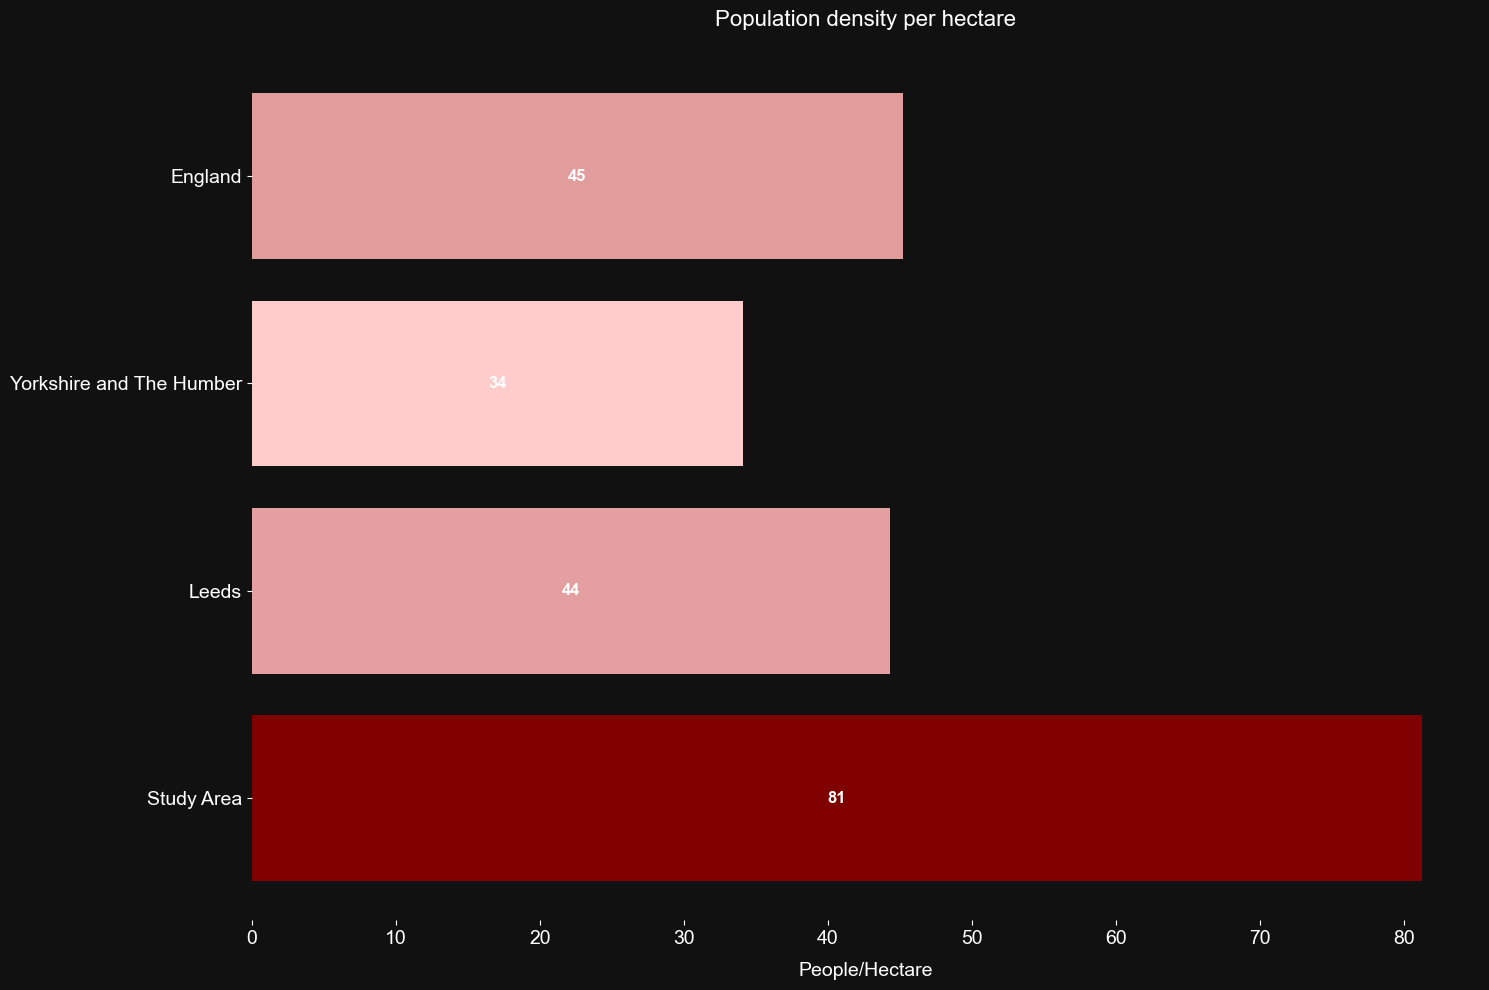

In [38]:
selected_cols = [
    'mid_2021_people_per_ha',
    ]

plot_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Population density per hectare',
    x_axis_label='People/Hectare',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='upper right',
    legend_location_x=1.0,
    legend_location_y=1.0,
    show_legend=False, 
    text_color='white',
    background_color='#111',
    label_threshold=0,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Population_density_per_hectare.png',
    dpi=300
)

# Household density

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\household_density_per_hectare.png


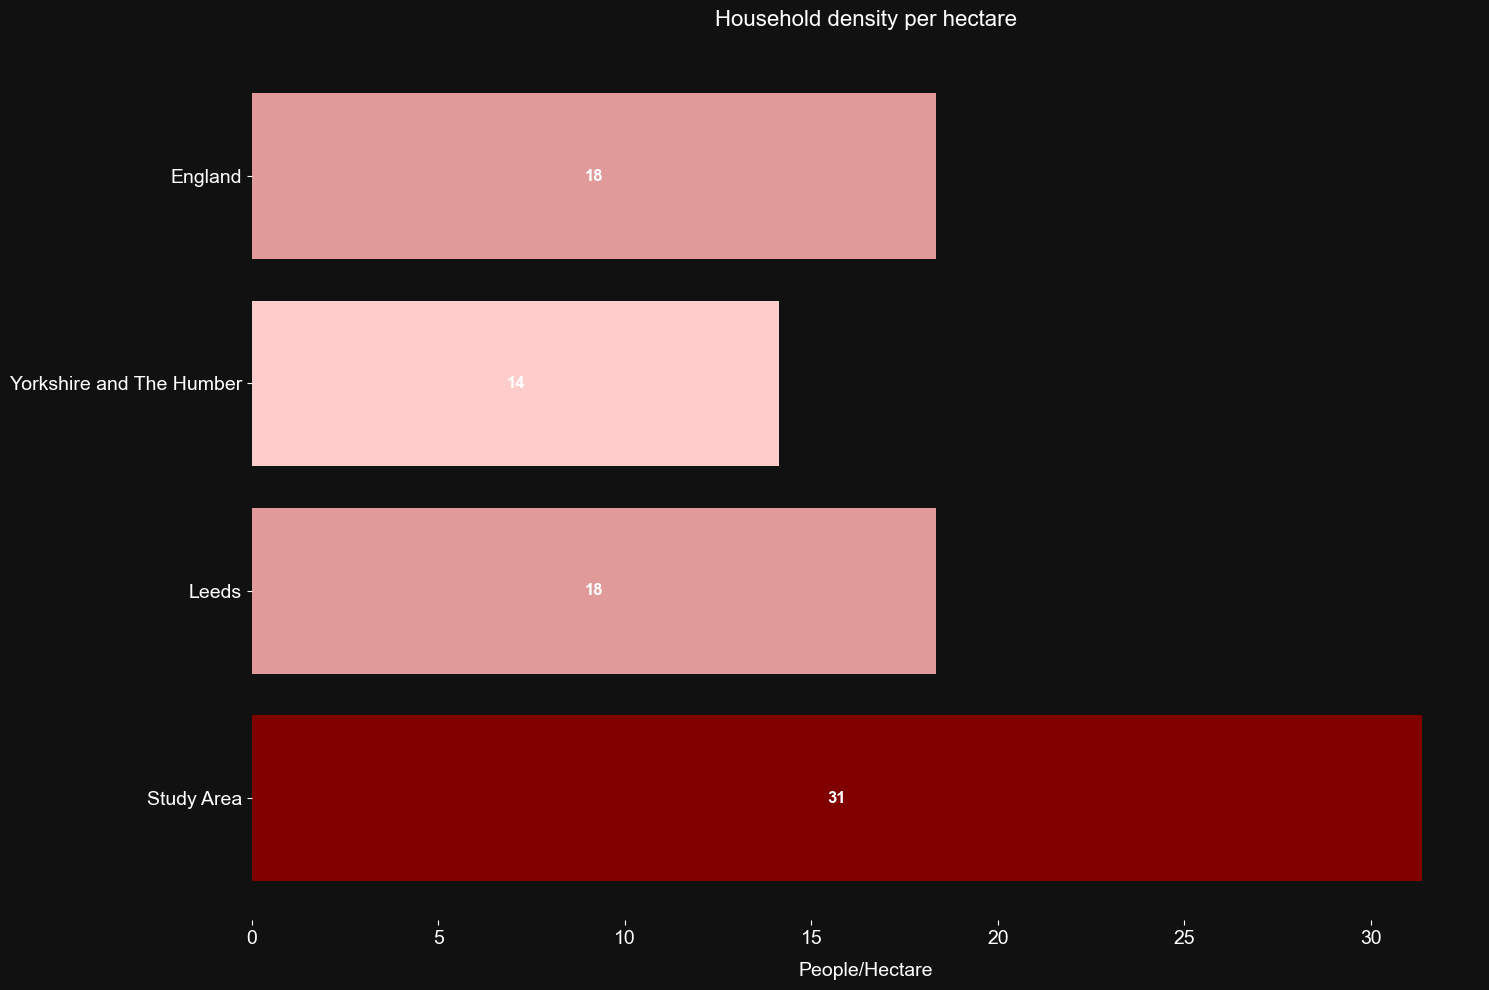

In [39]:
selected_cols = [
    '2021_households_per_ha',
    ]

plot_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Household density per hectare',
    x_axis_label='People/Hectare',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='upper right',
    legend_location_x=1.0,
    legend_location_y=1.0,
    show_legend=False, 
    text_color='white',
    background_color='#111',
    label_threshold=0,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='household_density_per_hectare.png',
    dpi=300
)

# Change in population - 10 years

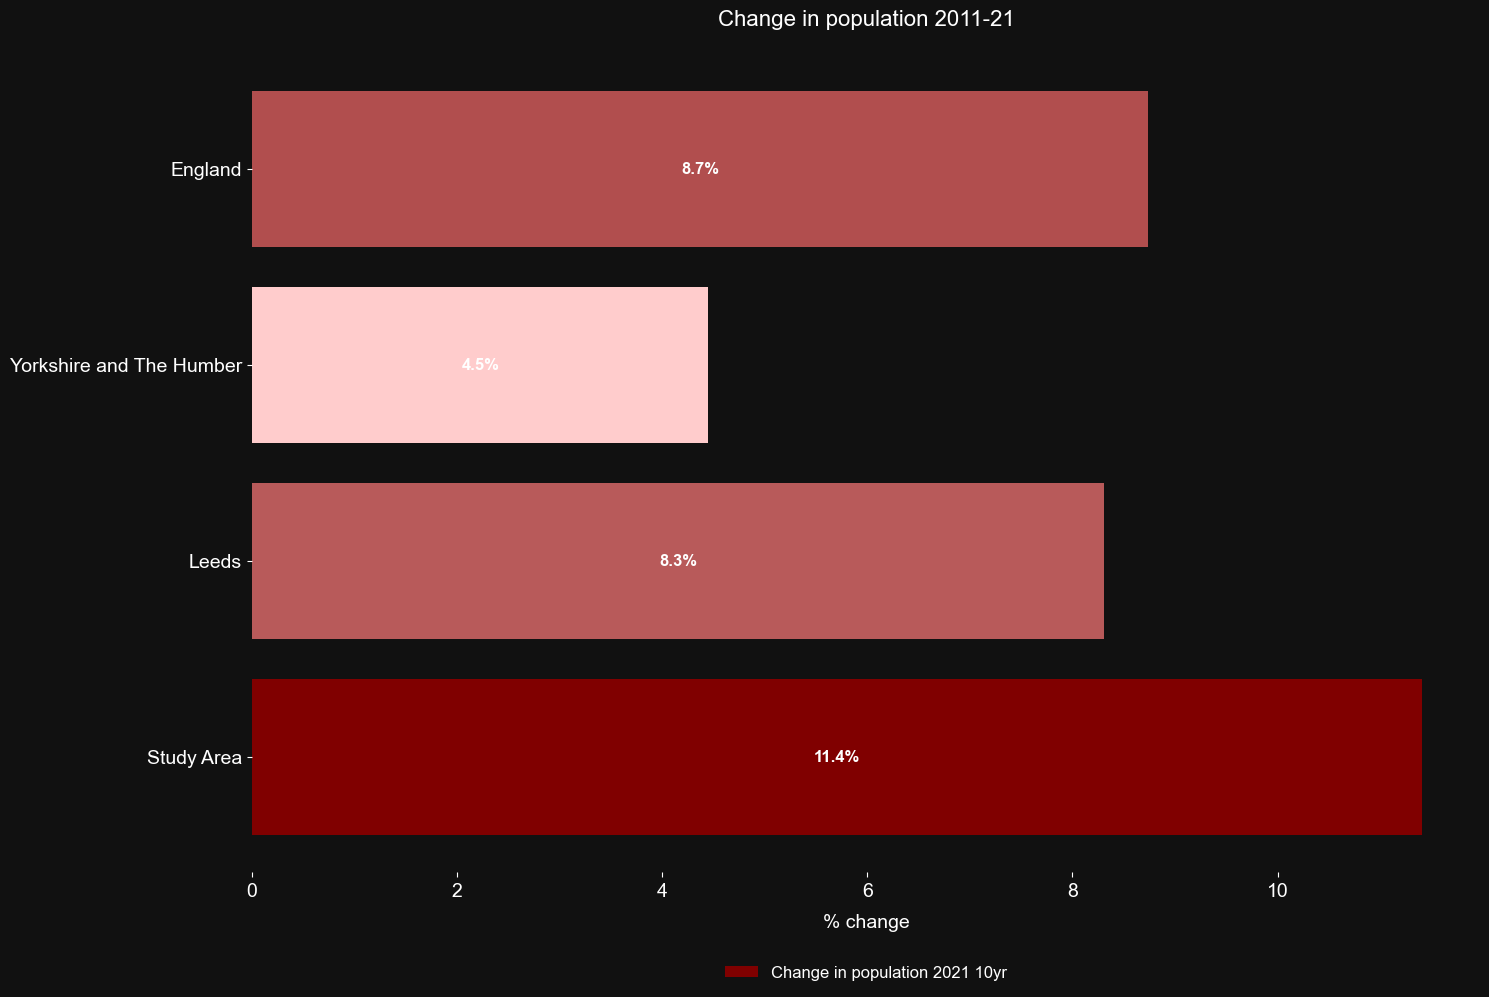

In [51]:
selected_cols = [
    'change_in_population_2021_10yr',
    ]

plot_change_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    proportion_column='mid_2011_population_count',  # NEW ARGUMENT
    chart_title='Change in population 2011-21',
    x_axis_label='% change',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.15,
    show_legend=True,
    text_color='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=False,
    image_path=None,
    image_name='Change_in_population_2011_21.png',
    dpi=300
)

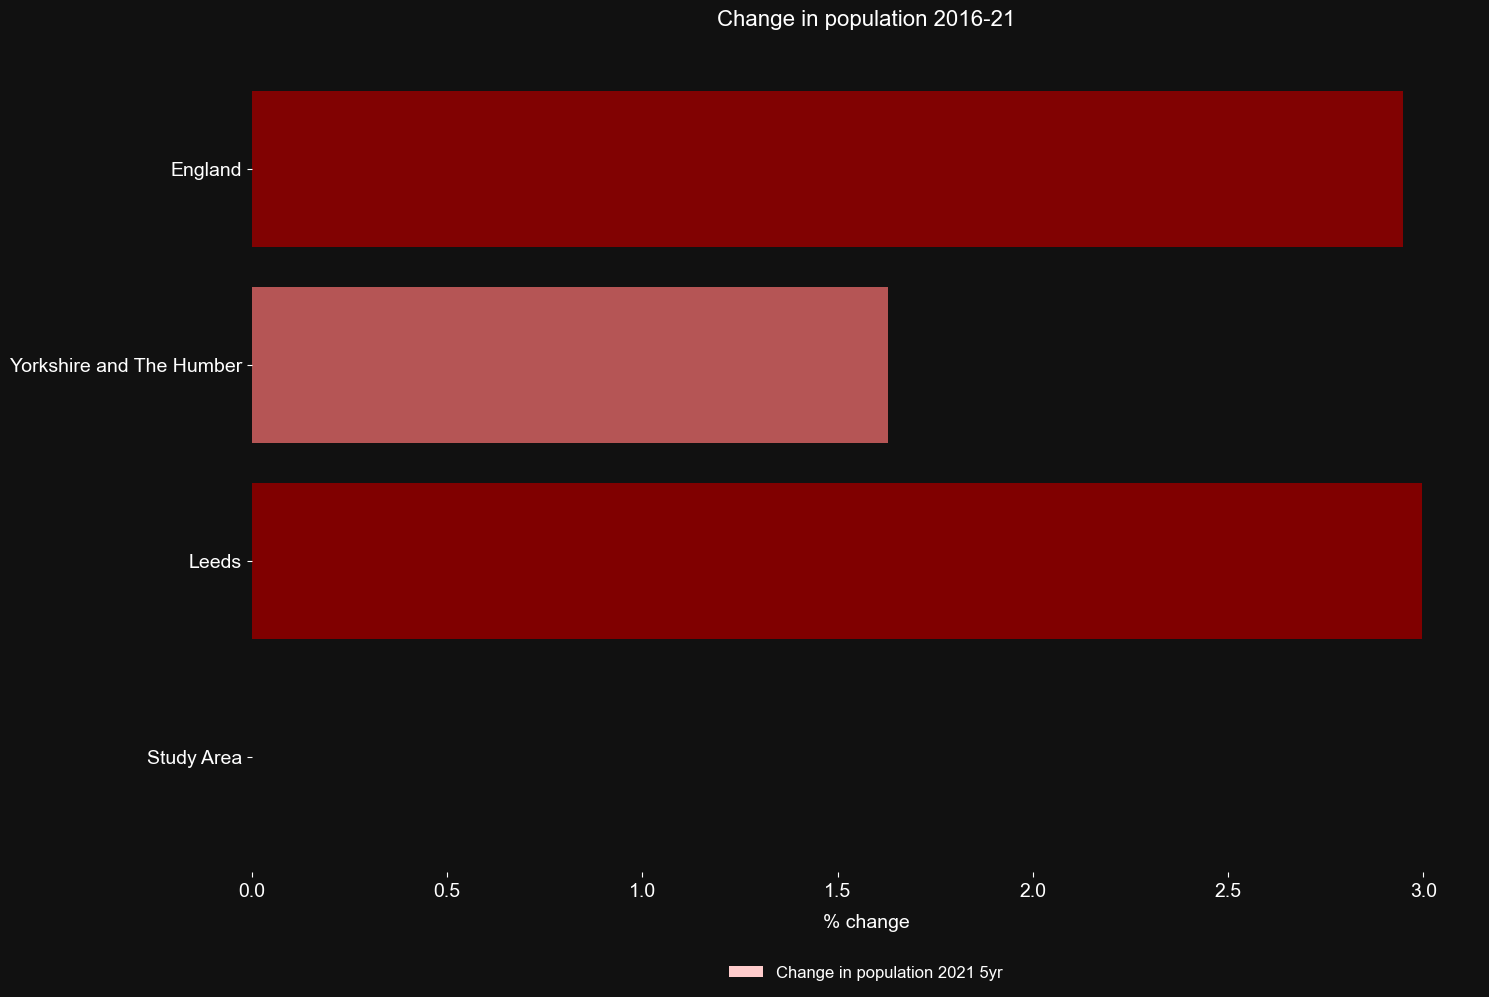

In [53]:
selected_cols = [
    'change_in_population_2021_5yr',
    ]

plot_change_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    proportion_column='mid_2016_population_count',  # NEW ARGUMENT
    chart_title='Change in population 2016-21',
    x_axis_label='% change',
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=12,
    legend_ncol=3,
    legend_y_offset=-0.15,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.15,
    show_legend=True,
    text_color='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=False,
    image_path=None,
    image_name='Change_in_population_2016_21.png',
    dpi=300
)

# Education

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Education_qualification.png


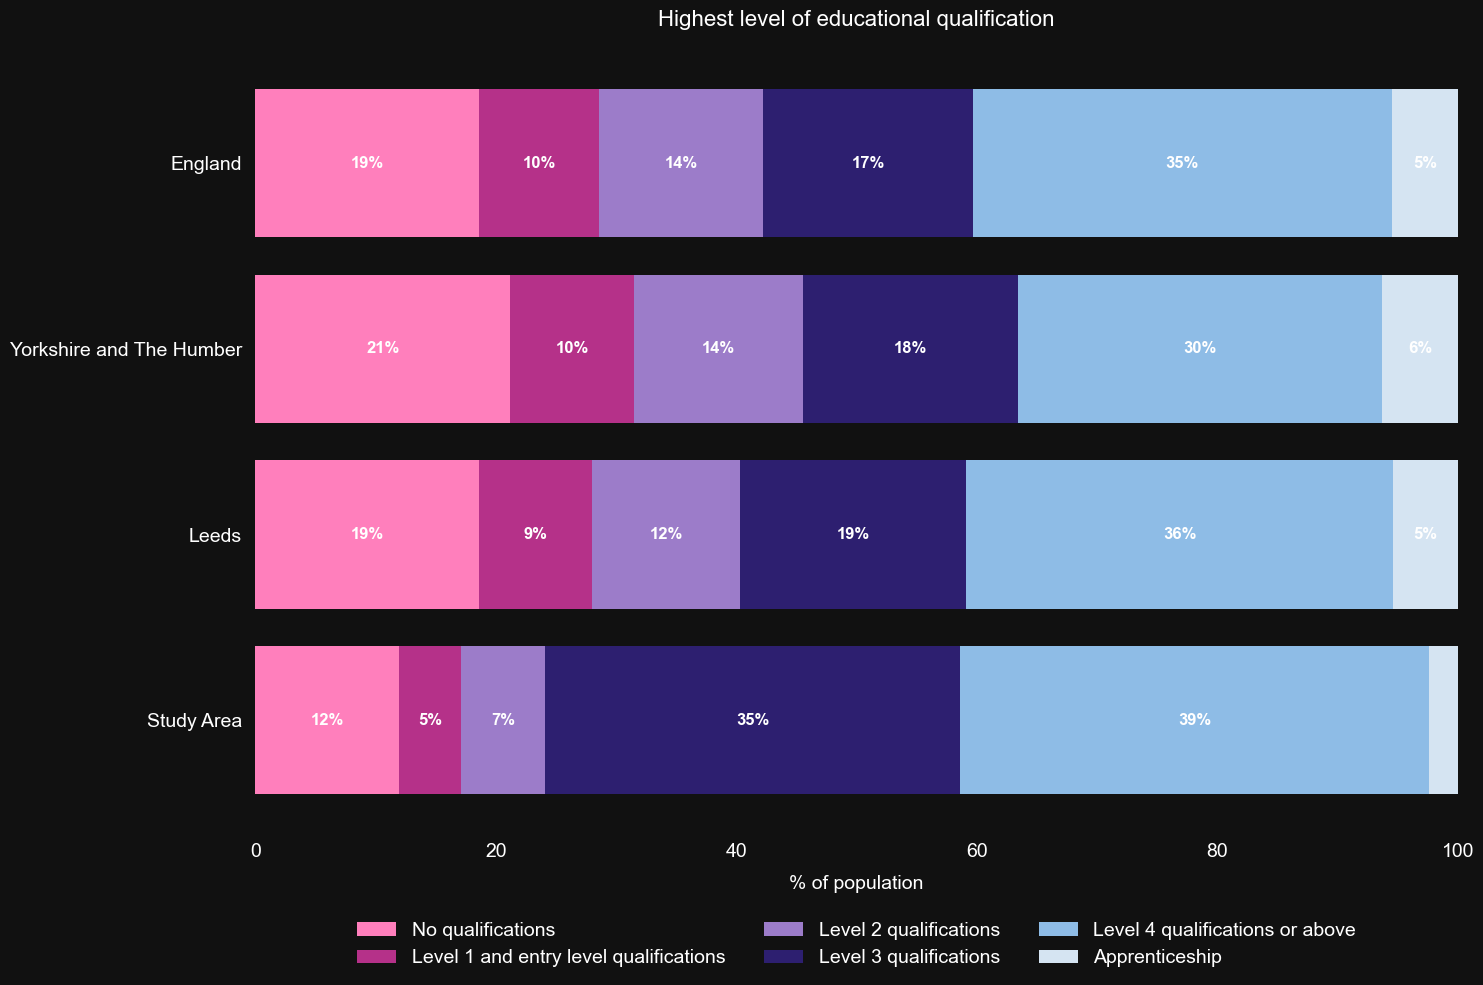

In [295]:
selected_cols = [
    'no_qualifications_count',
    'level_1_and_entry_level_qualifications_count',
    'level_2_qualifications_count',
    'level_3_qualifications_count',
    'level_4_qualifications_or_above_count',
    'apprenticeship_count'
]

plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Highest level of educational qualification',
    x_axis_label='% of population',
    color_palette=None,
    auto_color_by_group=True,
    data_specific_palette=None,
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=14,
    legend_ncol=3,
    legend_y_offset=-0.3,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.2,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,              
    image_name='Education_qualification.png' # file name
)


# English proficiency

In [296]:
base_palette = {
    'main_language_english': '#1f77b4',         # Blue
    'main_language_not_english': '#ff7f0e'      # Orange
}

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\English proficiency.png


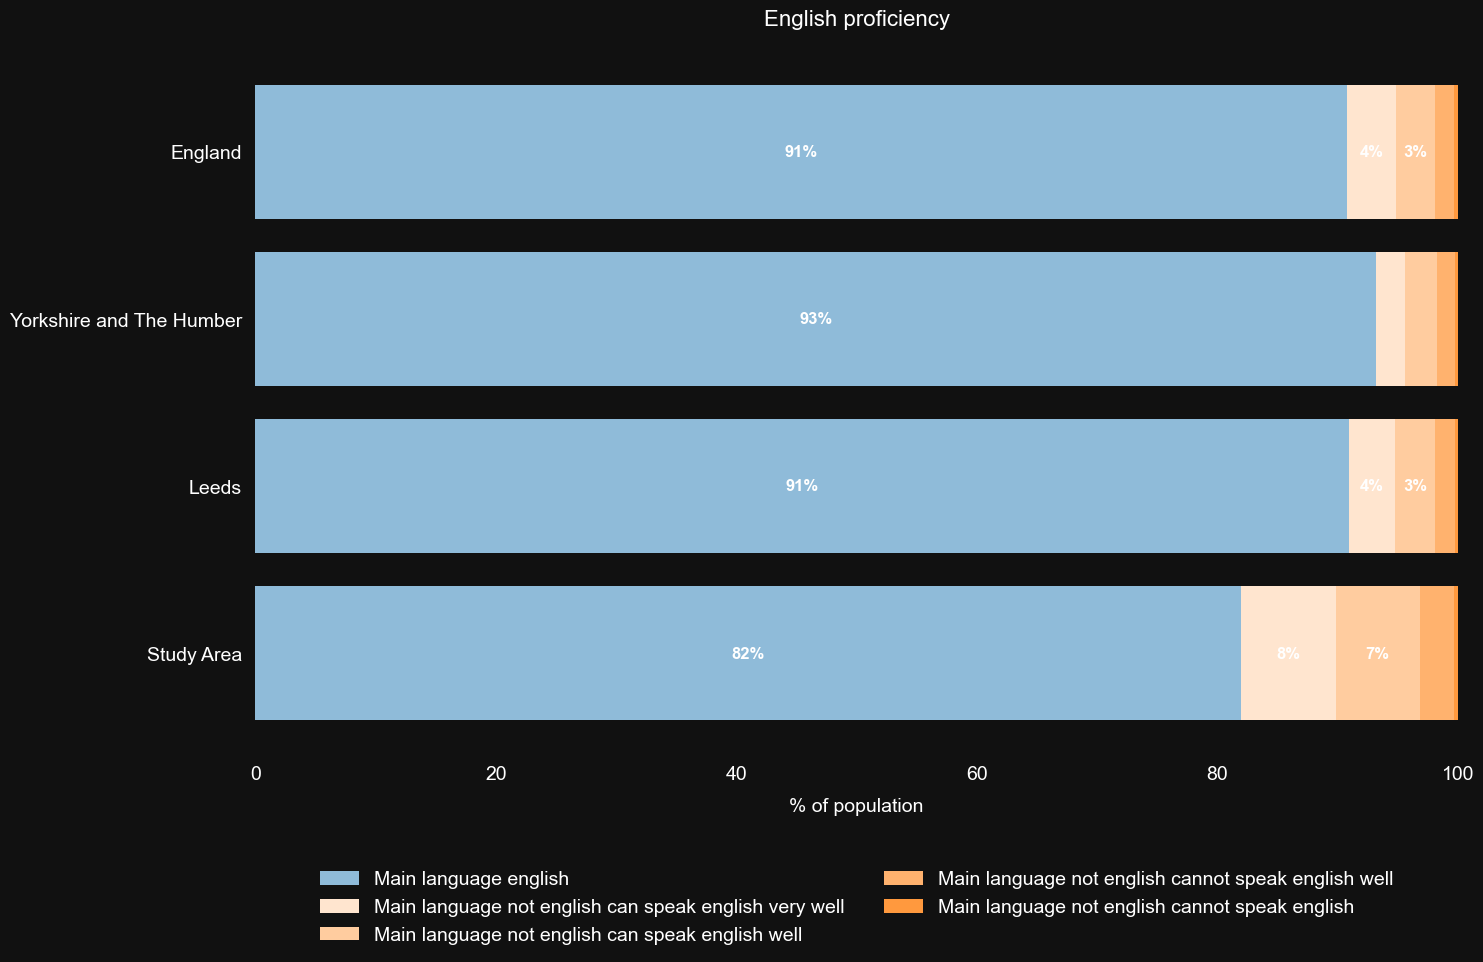

In [297]:
selected_cols = [
    'main_language_english_count',
    'main_language_not_english_can_speak_english_very_well_count',
    'main_language_not_english_can_speak_english_well_count',
    'main_language_not_english_cannot_speak_english_well_count',
    'main_language_not_english_cannot_speak_english_count'
]

plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='English proficiency',
    x_axis_label='% of population',
    color_palette=None,
    auto_color_by_group=True,
    data_specific_palette=base_palette,
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=14,
    legend_ncol=2,
    legend_y_offset=-0.3,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.3,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='English proficiency.png' # file name
)


# Ethnicity

In [257]:
# Define base colors for top-level groups
base_palette = {
    'asian': '#e6194b',             # bold red-pink
    'black': '#3cb44b',             # vibrant green
    'mixed_or_multiple': '#ffe119', # bright yellow
    'other': '#4363d8',             # deep blue
    'white': '#f58231'              # orange
}

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Ethnicity.png


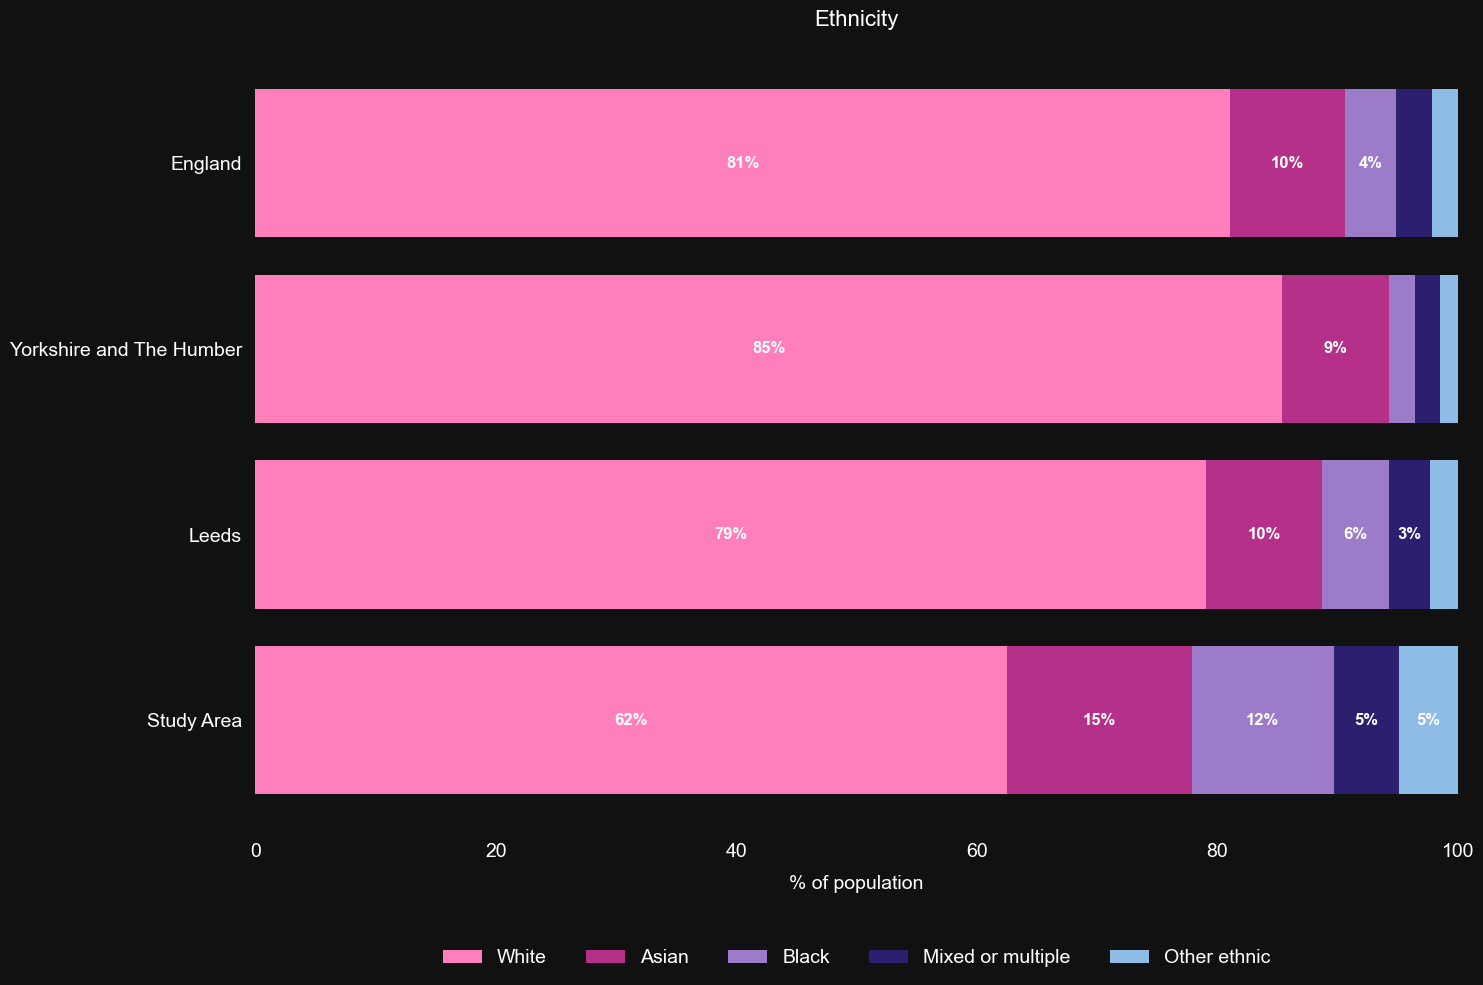

In [298]:
selected_cols = [
    'white_count',
    'asian_count',
    'black_count',
    'mixed_or_multiple_count',
    'other_ethnic_count',
]

plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Ethnicity',
    x_axis_label='% of population',
    color_palette=None,
    auto_color_by_group=True,
    data_specific_palette=None,
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=14,
    legend_ncol=5,
    legend_y_offset=-0.3,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.2,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Ethnicity.png' # file name
)


# Household composition

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Household composition.png


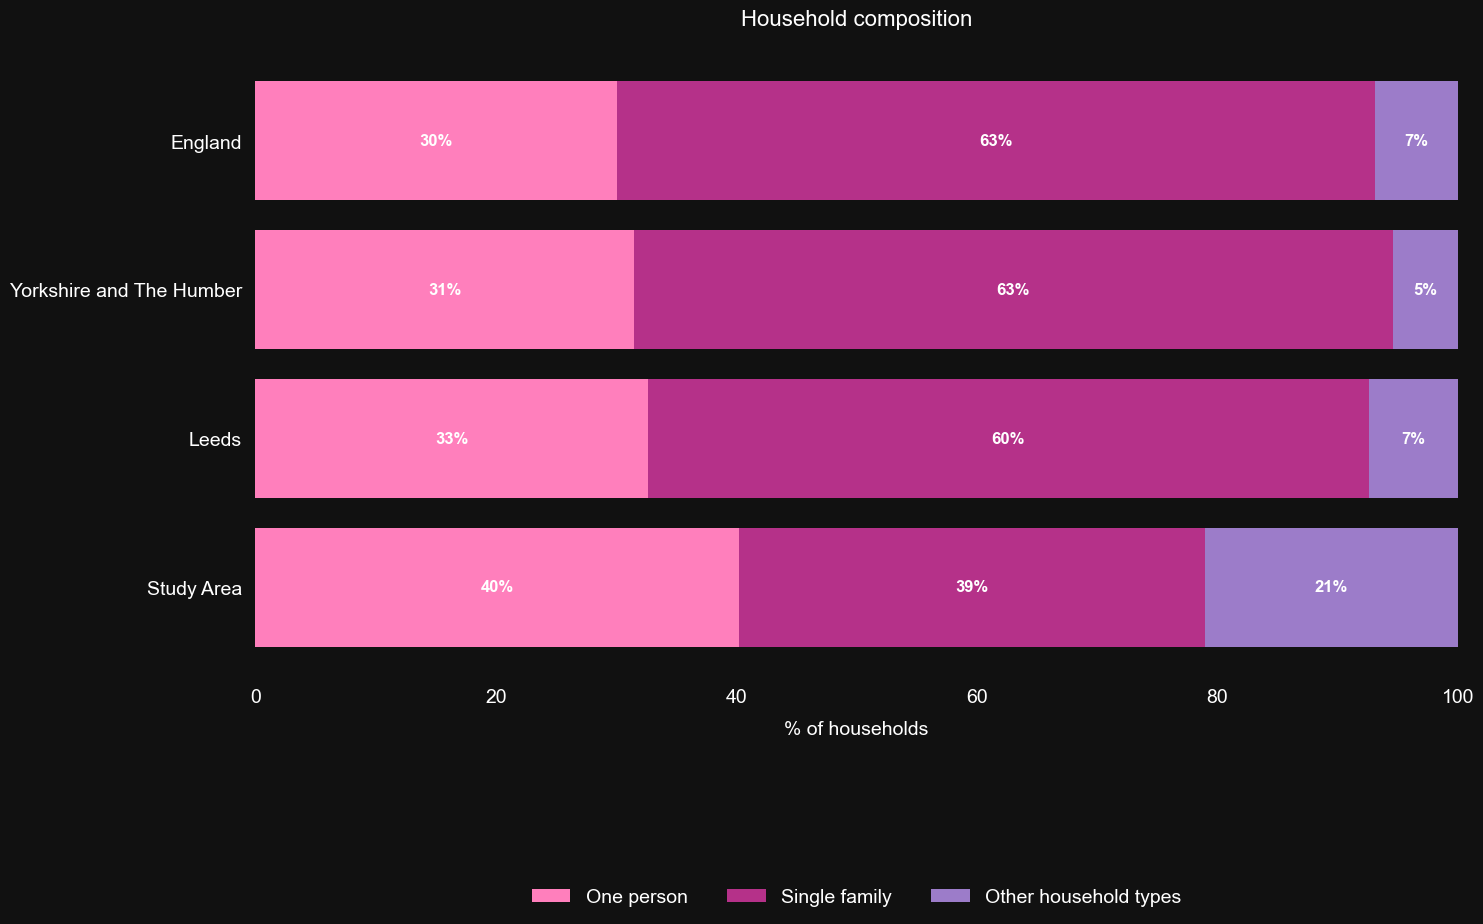

In [332]:
selected_cols = [
    'one_person_count',
    'single_family_count',
    'other_household_types_count'
]

plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Household composition',
    x_axis_label='% of households',
    color_palette=None,
    auto_color_by_group=True,
    data_specific_palette=None,
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=14,
    legend_ncol=3,
    legend_y_offset=-0.3,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.4,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Household composition.png' # file name
)


# Household size

In [329]:
refined_purple_shades = [
    '#ffe2ff', '#e6c8f1', '#cdafe4', '#b495d6', '#9c7cc9',
    '#8469aa', '#6d568c', '#55446e', '#3e3250'
]
color_palette = {col: color for col, color in zip(selected_cols, refined_purple_shades)}

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Household size.png


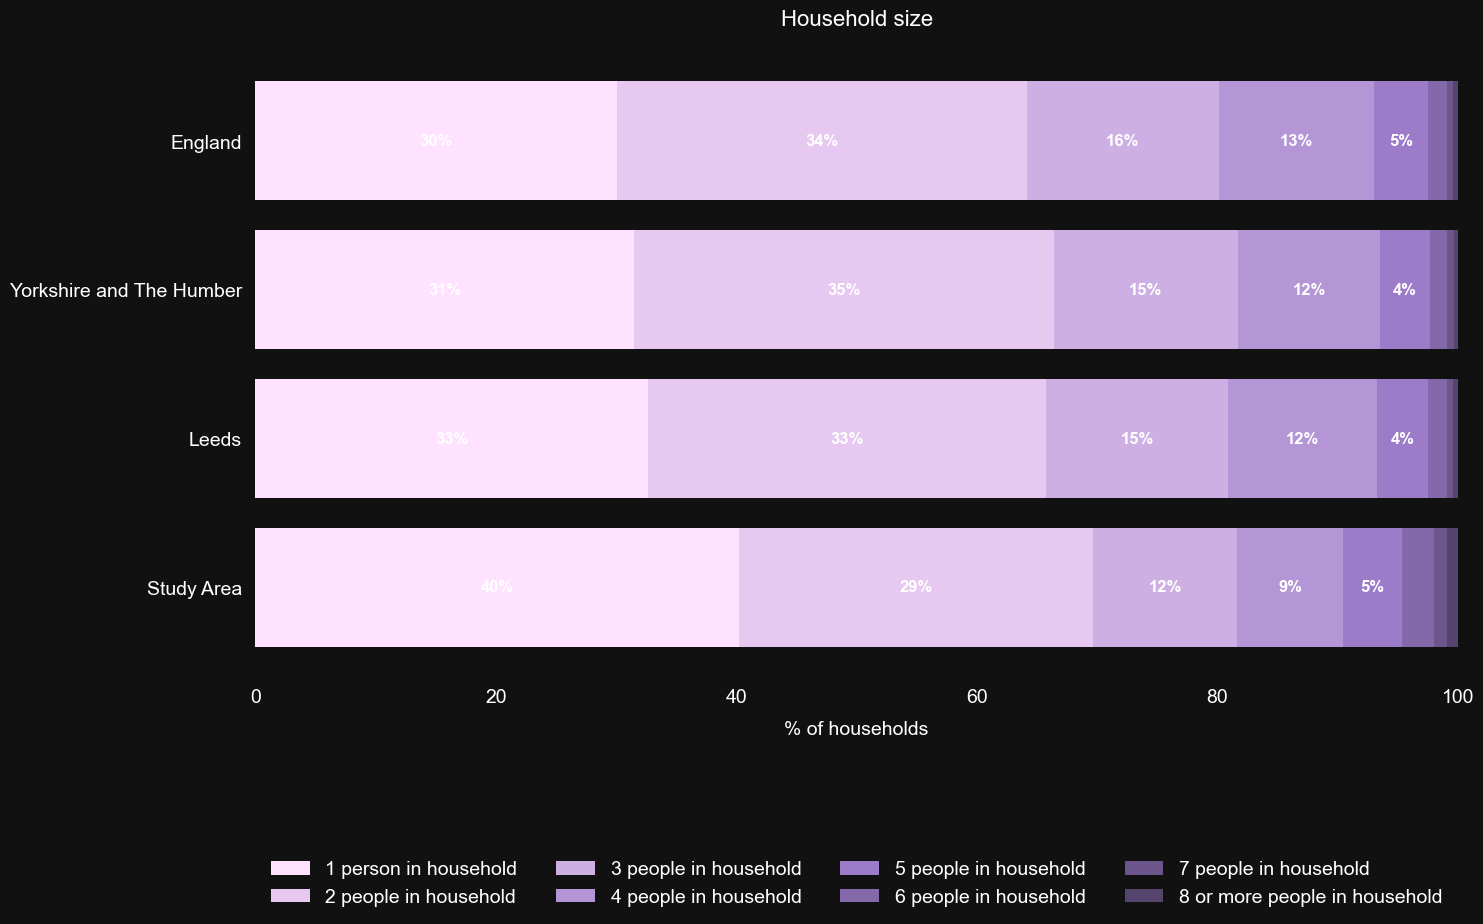

In [330]:
selected_cols = [
    '1 person in household_count',
    '2_people_in_household_count',
    '3_people_in_household_count',
    '4_people_in_household_count',
    '5_people_in_household_count',
    '6_people_in_household_count',
    '7_people_in_household_count',
    '8_or_more_people_in_household_count'
]

plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Household size',
    x_axis_label='% of households',
    color_palette=color_palette,
    auto_color_by_group=True,
    data_specific_palette=None,
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=14,
    legend_ncol=4,
    legend_y_offset=-0.3,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.4,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Household size.png' # file name
)


# Housing tenure

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Housing tenure.png


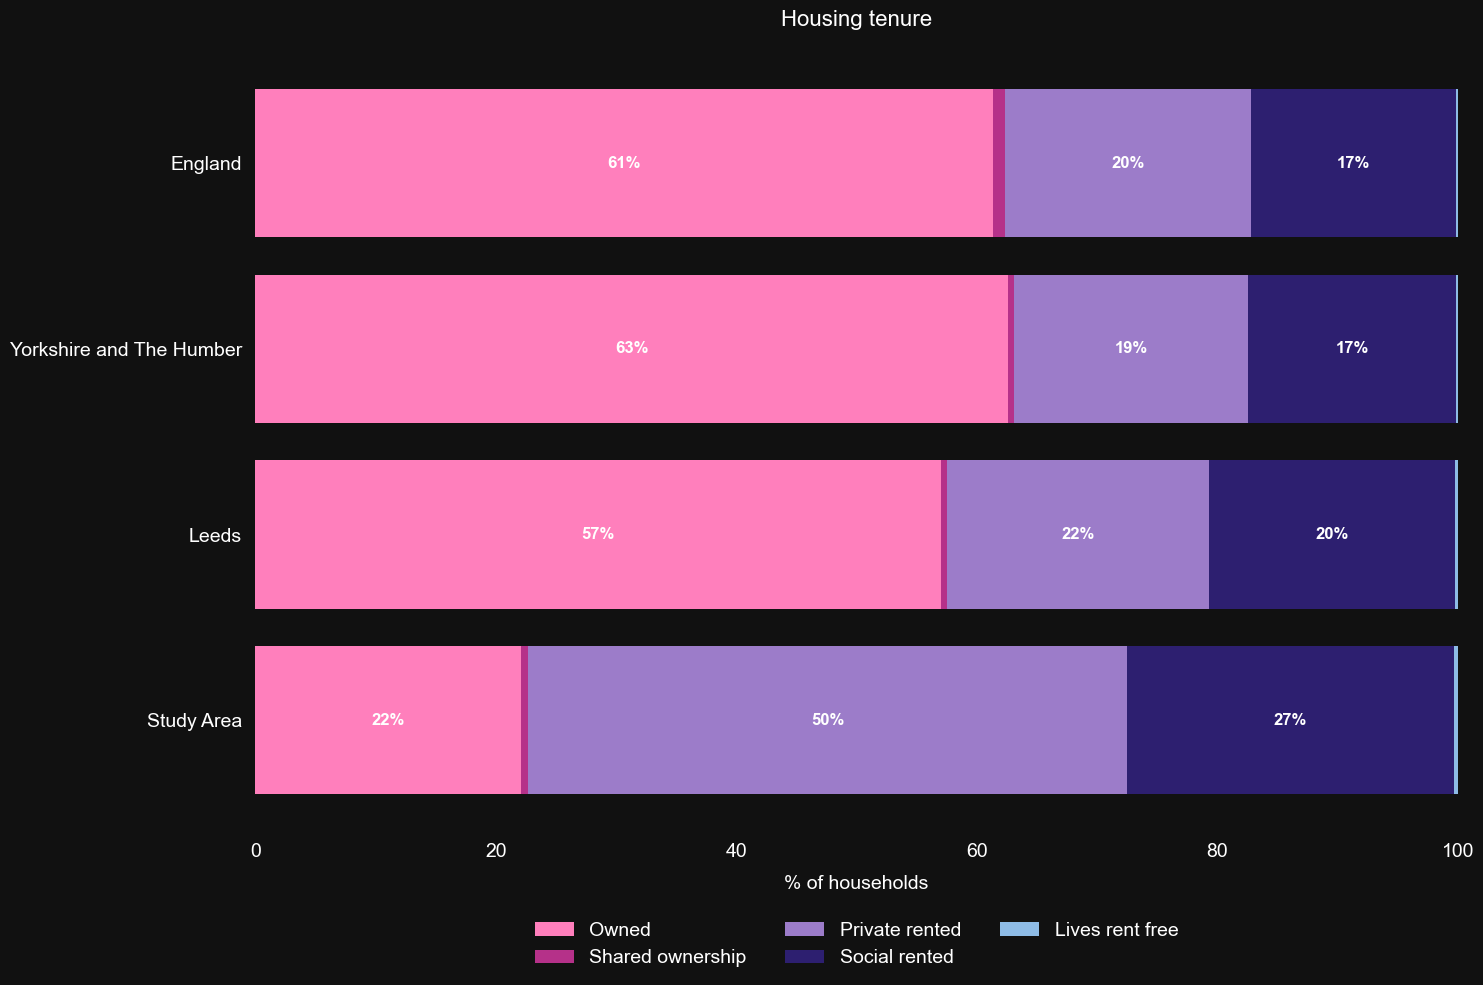

In [326]:
selected_cols = [
    'owned_count',
    'shared_ownership_count',
    'private_rented_count',
    'social_rented_count',    
    'lives_rent_free_count',
]

plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Housing tenure',
    x_axis_label='% of households',
    color_palette=None,
    auto_color_by_group=True,
    data_specific_palette=None,
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=14,
    legend_ncol=3,
    legend_y_offset=-0.3,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.2,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Housing tenure.png' # file name
)


# Industries residents work in

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Industries residents work in.png


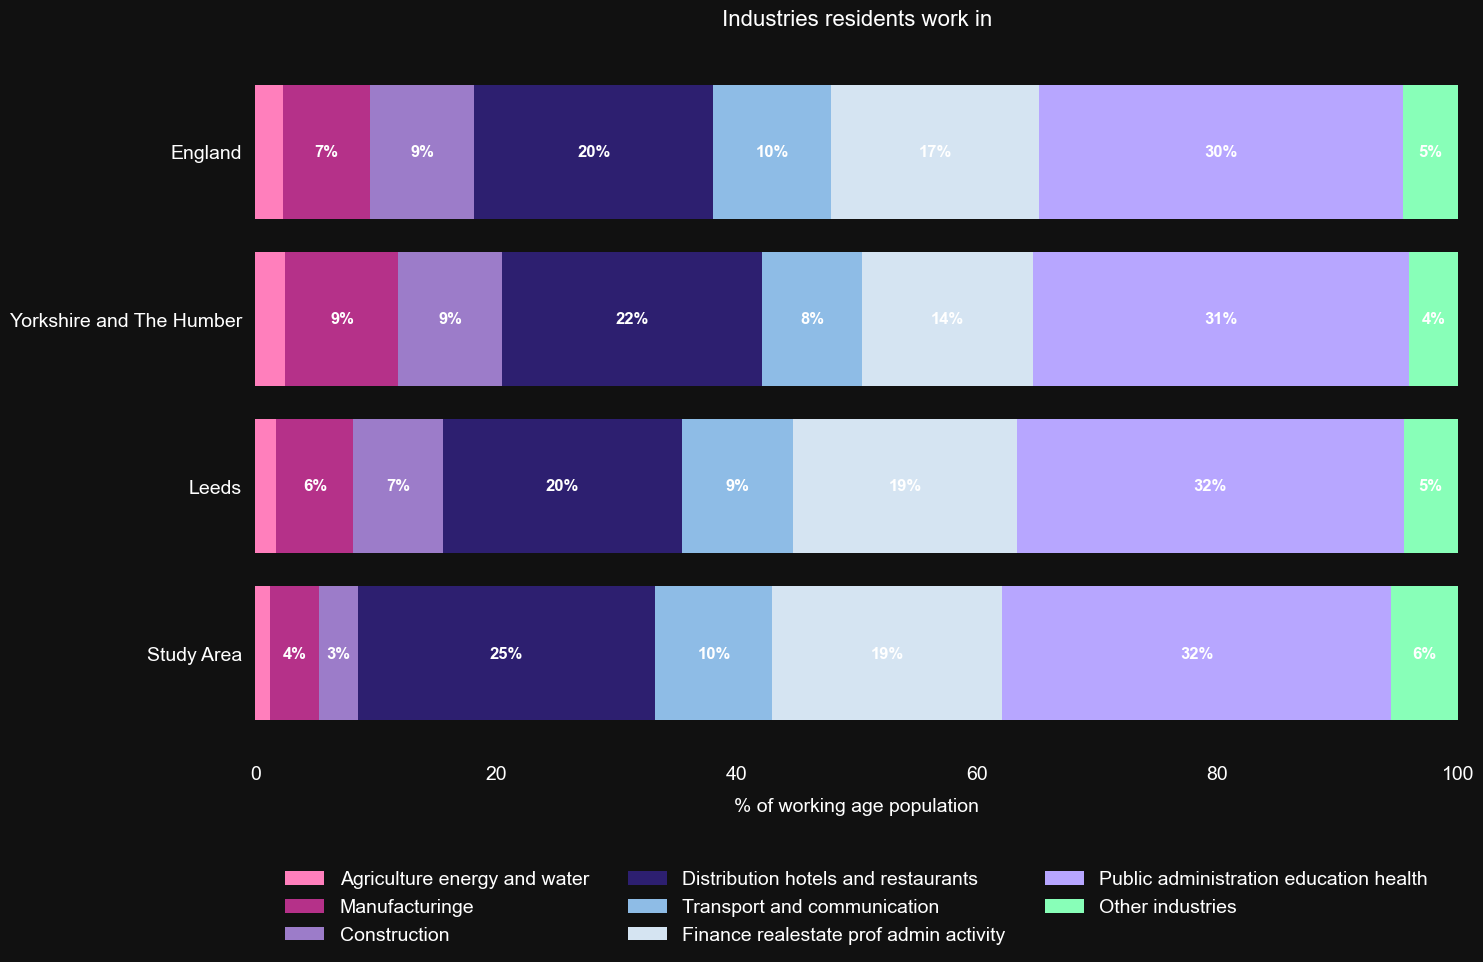

In [325]:
selected_cols = [
    'agriculture_energy_and_water_count',
    'manufacturinge_count',
    'construction_count',
    'distribution_hotels_and_restaurants_count',
    'transport_and_communication_count',
    'finance_realestate_prof_admin_activity_count',
    'public_administration_education_health_count',
    'other_industries_count',
]

plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Industries residents work in',
    x_axis_label='% of working age population',
    color_palette=None,
    auto_color_by_group=True,
    data_specific_palette=None,
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=14,
    legend_ncol=3,
    legend_y_offset=-0.3,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.3,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Industries residents work in.png' # file name
)


# National Identity

In [316]:
base_palette = {
    'british': '#e6194b',     # bold red-pink
    'cornish': '#4363d8',     # deep blue
    'english': '#3cb44b',     # vibrant green
    'irish': '#f58231',       # strong orange
    'northern': '#ffe119',    # vivid yellow
    'scottish': '#46f0f0',    # bright teal
    'welsh': '#f032e6',       # bright magenta
    'any': '#a9a9a9',        # neutral grey
    'other': '#911eb4',    # rich purple'
}

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\National Identity.png


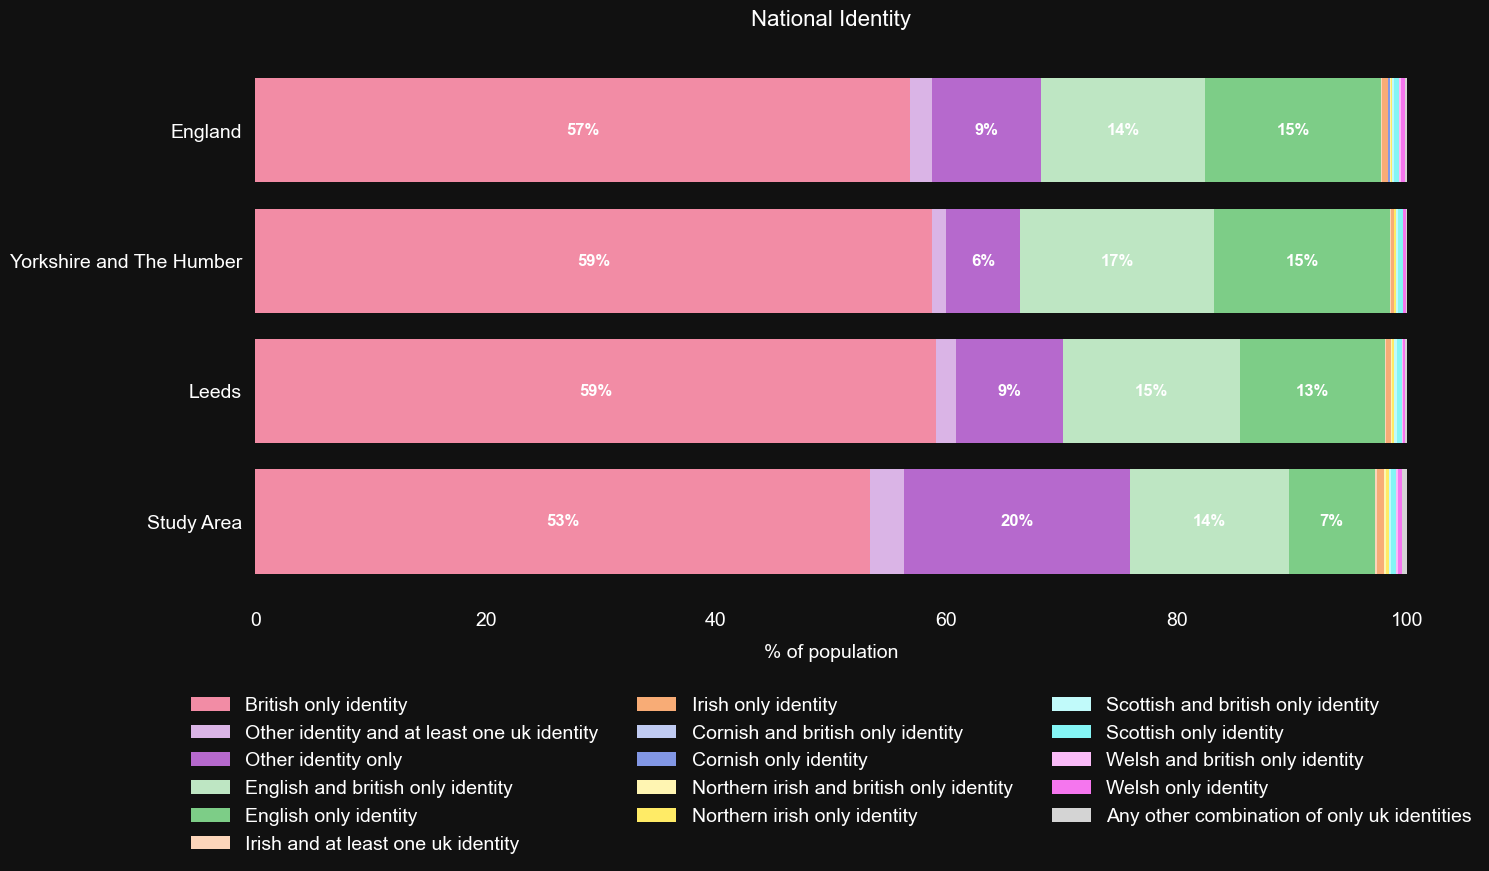

In [317]:
selected_cols = [
    'british_only_identity_count',
    'other_identity_and_at_least_one_uk_identity_count',
    'other_identity_only_count',
    'english_and_british_only_identity_count',
    'english_only_identity_count',
    'irish_and_at_least_one_uk_identity_count',
    'irish_only_identity_count',
    'cornish_and_british_only_identity_count',
    'cornish_only_identity_count',
    'northern_irish_and_british_only_identity_count',
    'northern_irish_only_identity_count',    
    'scottish_and_british_only_identity_count',
    'scottish_only_identity_count',
    'welsh_and_british_only_identity_count',
    'welsh_only_identity_count',
    'any_other_combination_of_only_uk_identities_count',
    
    
]

plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='National Identity',
    x_axis_label='% of population',
    color_palette=None,
    auto_color_by_group=True,
    data_specific_palette=base_palette,
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=14,
    legend_ncol=3,
    legend_y_offset=-0.3,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.5,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='National Identity.png' # file name
)


# Age

In [318]:
# Base colors per age group
group_colors = {
    'early_childhood': '#1f77b4',  # blue
    'preteens': '#2ca02c',         # green
    'working_age': '#ff7f0e',      # orange
    'seniors': '#9467bd'           # purple
}

# Grouped age columns
age_groups = {
    'early_childhood': [
        'aged_2_years_and_under_count',
        'aged_3_to_4_years_count',
        'aged_5_to_7_years_count',
        'aged_8_to_9_years_count'
    ],
    'preteens': [
        'aged_10_to_14_years_count',
        'aged_15_years_count'
    ],
    'working_age': [
        'aged_16_to_17_years_count',
        'aged_18_to_19_years_count',
        'aged_20_to_24_years_count',
        'aged_25_to_29_years_count',
        'aged_30_to_34_years_count',
        'aged_35_to_39_years_count',
        'aged_40_to_44_years_count',
        'aged_45_to_49_years_count',
        'aged_50_to_54_years_count',
        'aged_55_to_59_years_count',
        'aged_60_to_64_years_count',
        'aged_65_years_count'
    ],
    'seniors': [
        'aged_66_to_69_years_count',
        'aged_70_to_74_years_count',
        'aged_75_to_79_years_count',
        'aged_80_to_84_years_count',
        'aged_85_years_and_over_count'
    ]
}

# Function to generate hues from light → base → dark
def generate_adjusted_shades(base_color, count):
    rgb = mcolors.to_rgb(base_color)
    lighter = tuple(min(1, c + 0.5 * (1 - c)) for c in rgb)  # lighten by 50%
    darker = tuple(max(0, c * 0.5) for c in rgb)             # darken by 50%
    cmap = mcolors.LinearSegmentedColormap.from_list("custom", [lighter, rgb, darker])
    return [mcolors.to_hex(cmap(i / (count - 1))) for i in range(count)]

# Generate final palette
final_adjusted_palette = {}
for group, columns in age_groups.items():
    shades = generate_adjusted_shades(group_colors[group], len(columns))
    for col, shade in zip(columns, shades):
        final_adjusted_palette[col] = shade


Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Age.png


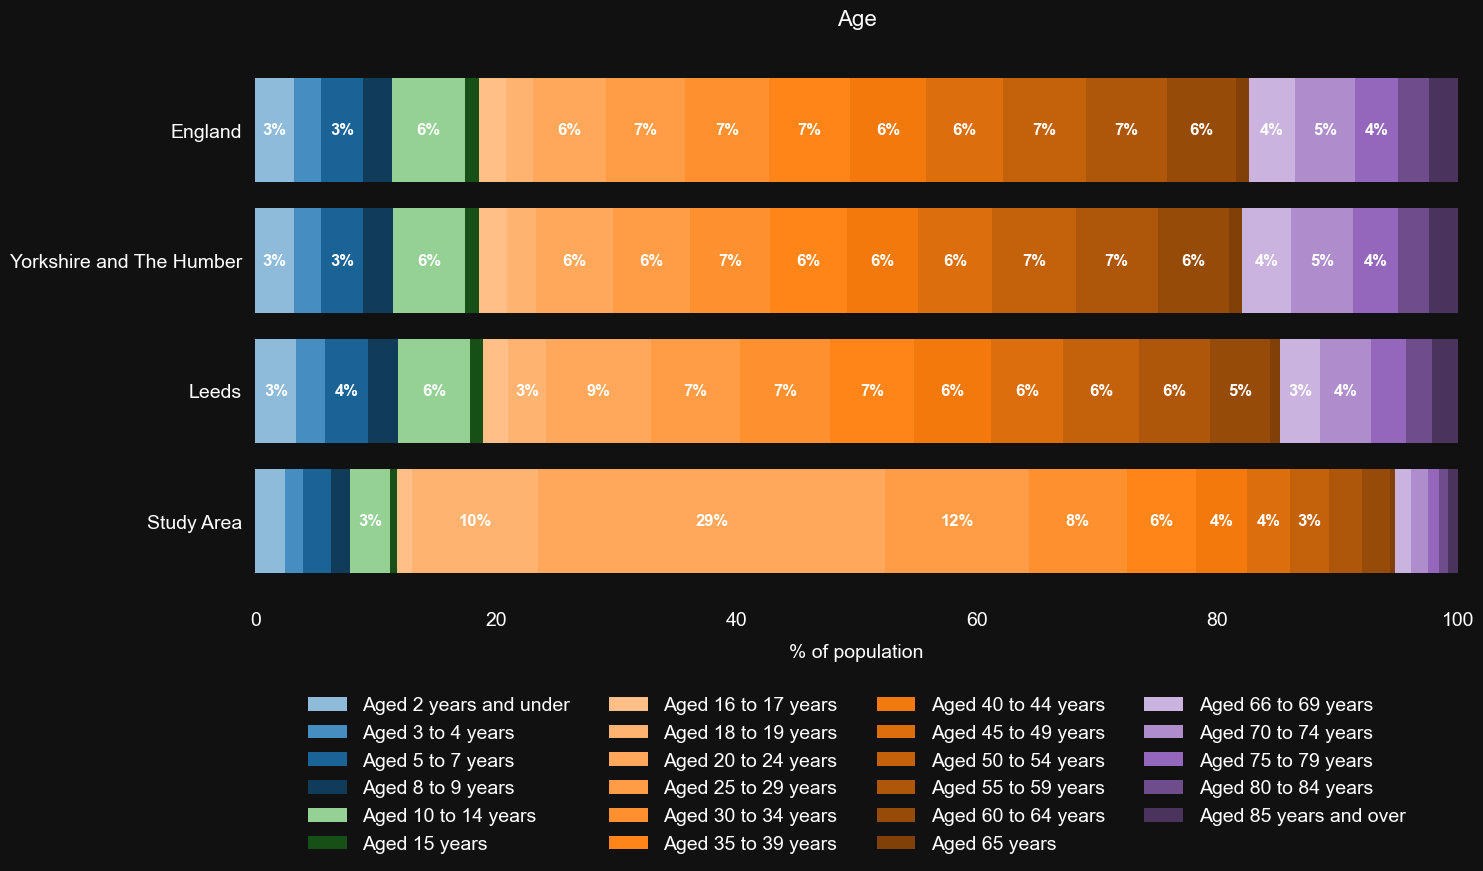

In [320]:
plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    list(final_adjusted_palette.keys()),
    chart_title='Age',
    x_axis_label='% of population',
    color_palette=final_adjusted_palette,
    auto_color_by_group=False,
    data_specific_palette=None,
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=14,
    legend_ncol=4,
    legend_y_offset=-0.3,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.5,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Age.png' # file name
)


# Religion

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Religion.png


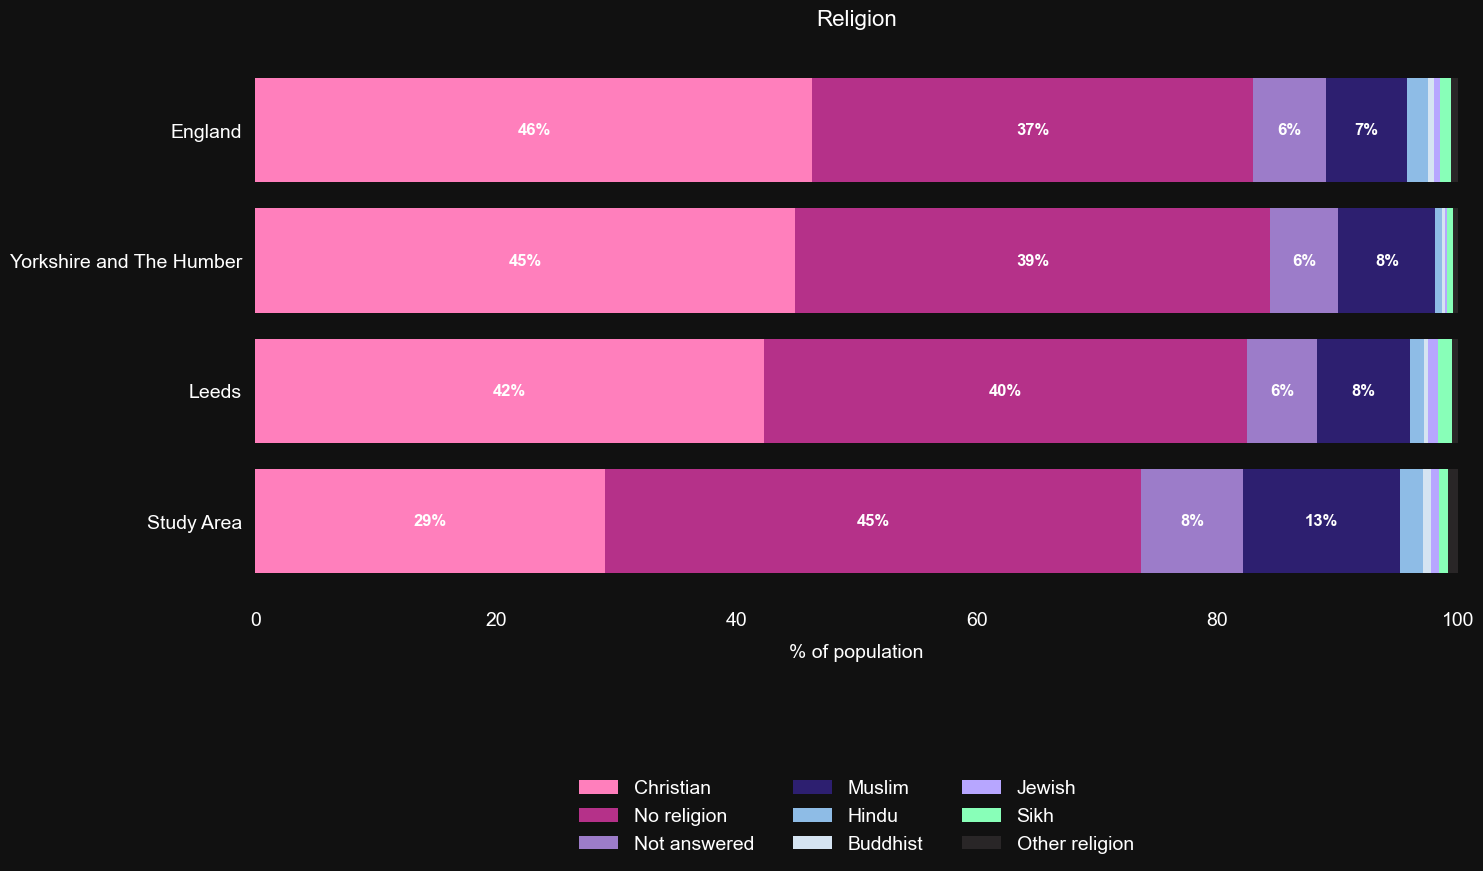

In [324]:
selected_cols = [    
    'christian_count',
    'no_religion_count',
    'not_answered_count',
    'muslim_count',
    'hindu_count',
    'buddhist_count',
    'jewish_count',    
    'sikh_count',    
    'other_religion_count',
]

plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Religion',
    x_axis_label='% of population',
    color_palette=None,
    auto_color_by_group=True,
    data_specific_palette=None,
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=14,
    legend_ncol=3,
    legend_y_offset=-0.3,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.5,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Religion.png' # file name
)


# Student Age Groups

In [347]:
refined_purple_shades = [
    '#ffe2ff', '#e6c8f1', '#cdafe4', '#b495d6', '#9c7cc9',
    '#8469aa', '#6d568c', '#55446e', '#3e3250'
]
color_palette = {col: color for col, color in zip(selected_cols, refined_purple_shades)}

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Student Age Groups.png


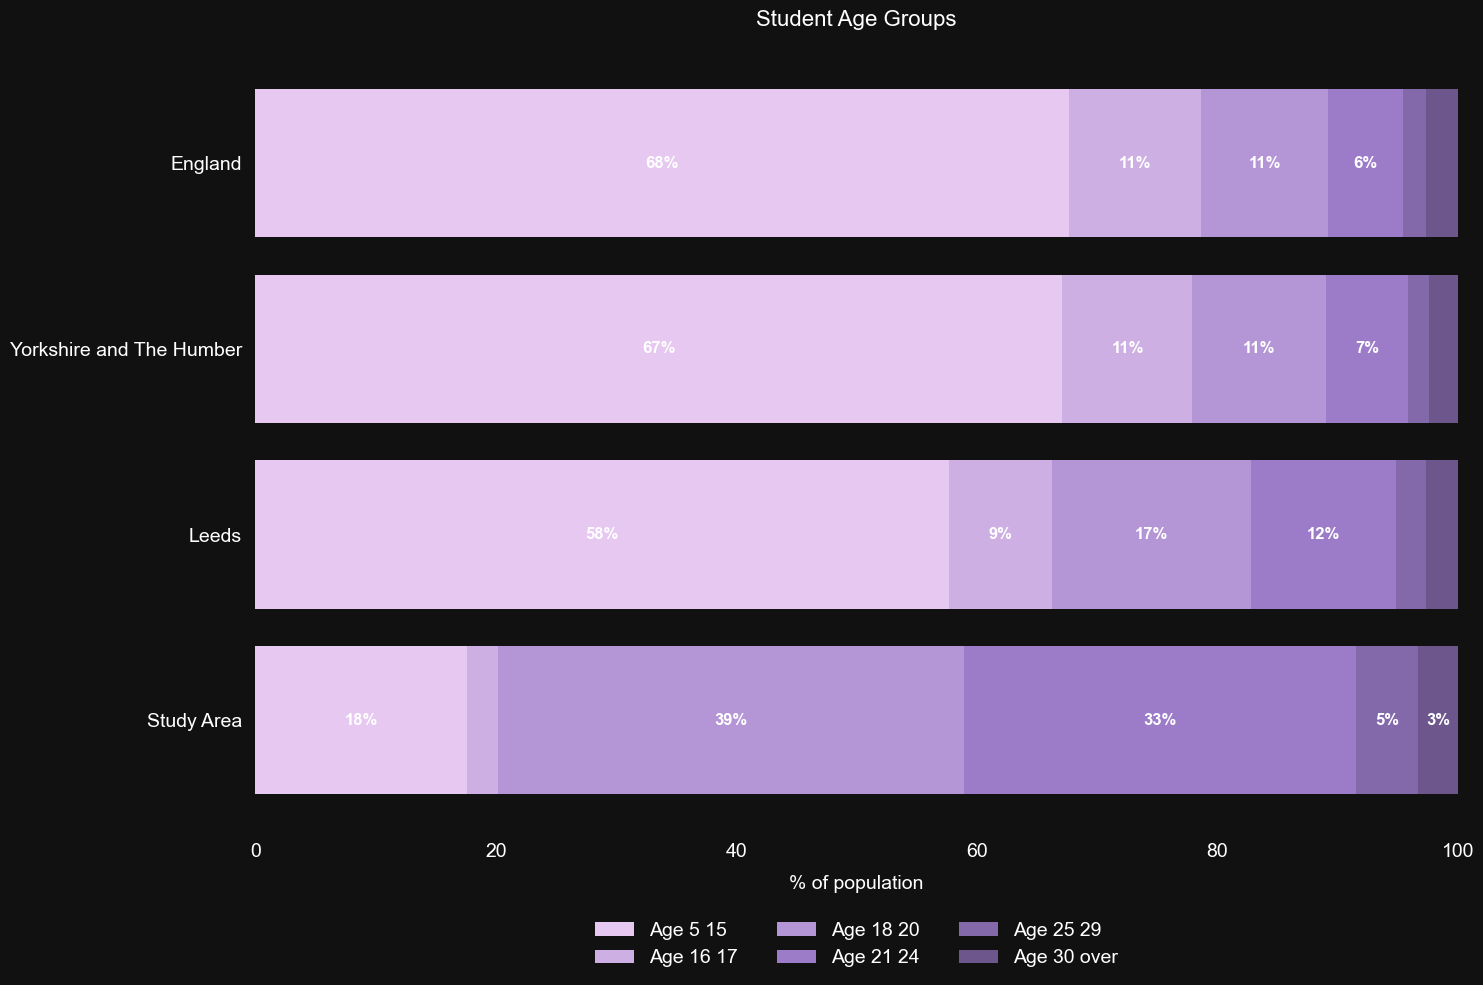

In [353]:
selected_cols = [    
    'age_5_15_count',
    'age_16_17_count',
    'age_18_20_count',
    'age_21_24_count',
    'age_25_29_count',
    'age_30_over_count',
]

plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Student Age Groups',
    x_axis_label='% of population',
    color_palette=color_palette,
    auto_color_by_group=True,
    data_specific_palette=None,
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=14,
    legend_ncol=3,
    legend_y_offset=-0.3,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.2,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Student Age Groups.png' # file name
)


# Student Accommodation Type

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Student Accommodation Type.png


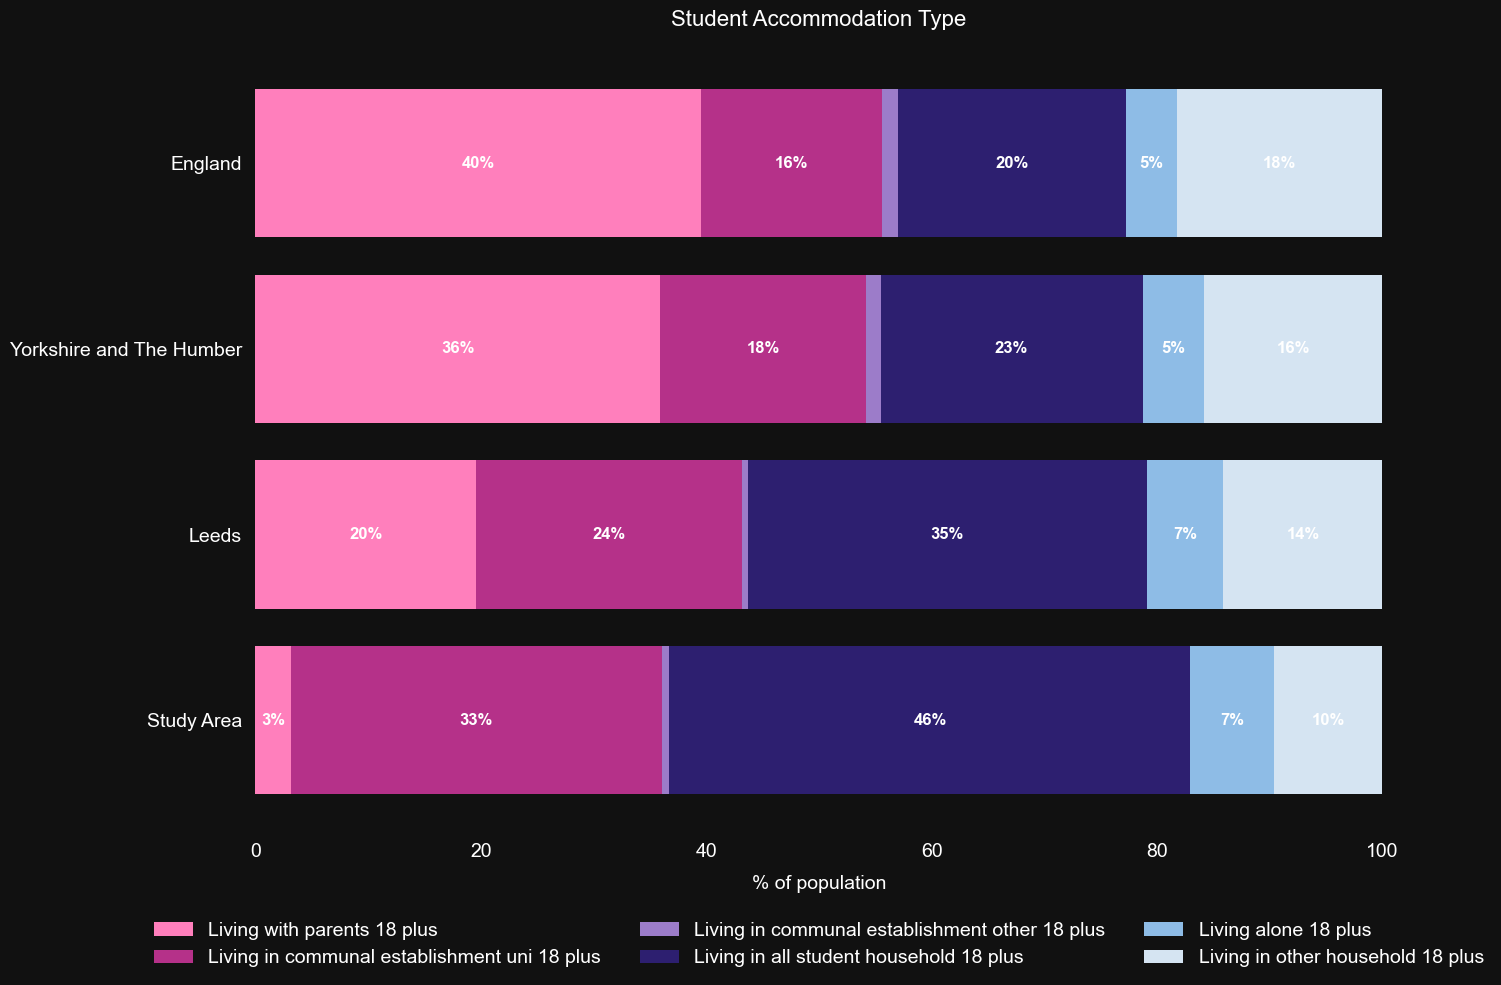

In [369]:
selected_cols = [    
    'living_with_parents_18_plus_count',
    'living_in_communal_establishment_uni_18_plus_count',
    'living_in_communal_establishment_other_18_plus_count',
    'living_in_all_student_household_18_plus_count',
    'living_alone_18_plus_count',
    'living_in_other_household_18_plus_count',
]

plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Student Accommodation Type',
    x_axis_label='% of population',
    color_palette=None,
    auto_color_by_group=True,
    data_specific_palette=None,
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=14,
    legend_ncol=3,
    legend_y_offset=-0.3,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.2,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Student Accommodation Type.png' # file name
)


# Accommodation type

Chart saved to: N:\2262_UoL MP Framework\WORKING\Graphics\Baseline Exports\Graphs\Accommodation Type.png


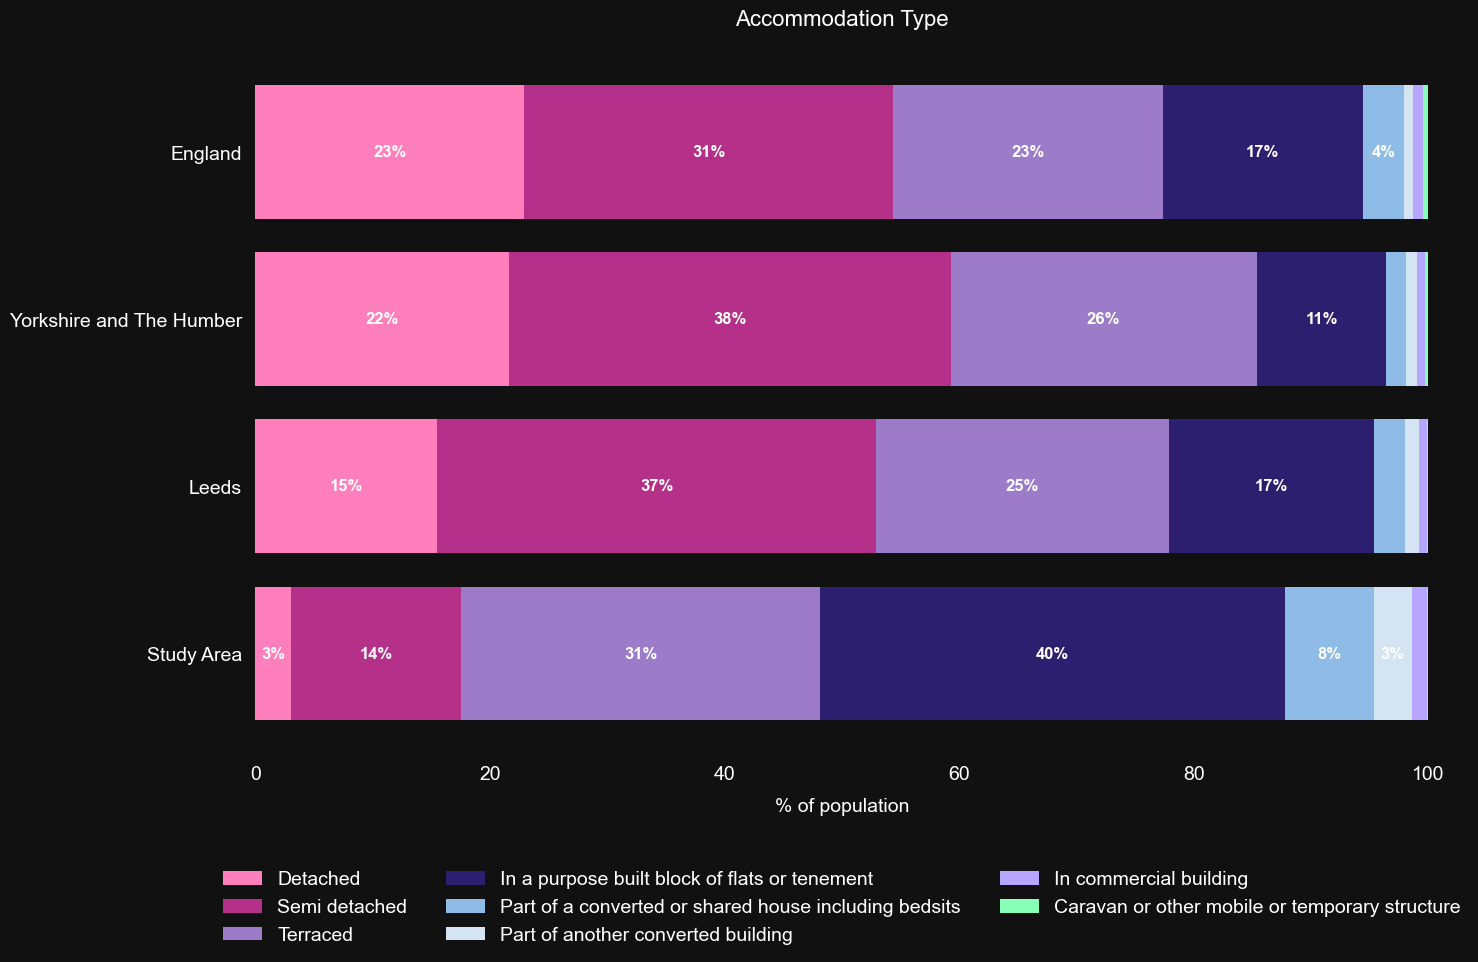

In [377]:
selected_cols = [    
    'detached_count',
    'semi_detached_count',
    'terraced_count',
    'in_a_purpose_built_block_of_flats_or_tenement_count',
    'part_of_a_converted_or_shared_house_including_bedsits_count',
    'part_of_another_converted_building_count',
    'in_commercial building_count',
    'caravan_or_other_mobile_or_temporary_structure_count'
]

plot_stacked_bar_chart(
    study_area_df, leeds_df, region_df, england_df,
    selected_cols,
    chart_title='Accommodation Type',
    x_axis_label='% of population',
    color_palette=None,
    auto_color_by_group=True,
    data_specific_palette=None,
    font_family='Arial',
    title_fontsize=16,
    axis_label_fontsize=14,
    tick_fontsize=14,
    label_fontsize=12,
    label_fontweight='bold',
    legend_title=None,
    legend_title_fontsize=14,
    legend_fontsize=14,
    legend_ncol=3,
    legend_y_offset=-0.3,
    legend_location='lower center',
    legend_location_x=0.5,
    legend_location_y=-0.3,
    legend_label_colour='white',
    background_color='#111',
    label_threshold=3,
    image_width=15,
    image_height=10,
    save_image=True,
    image_path=image_path,
    image_name='Accommodation Type.png' # file name
)
